# Projet 8 : Segmentation d'Images pour Véhicule Autonome - Notebook de Modélisation

Ce notebook constitue l'espace de travail principal pour le développement des modèles de segmentation d'images dans le cadre du Projet 8 d'OpenClassrooms. Il couvrira les étapes suivantes :
1.  Configuration de l'environnement et des accès.
2.  Chargement et exploration du dataset Cityscapes (un sous-ensemble).
3.  Prétraitement des données, incluant le mapping des classes et la création d'un générateur de données.
4.  Définition, entraînement et évaluation de plusieurs modèles de segmentation.
5.  Analyse des résultats et sélection du meilleur modèle.


## 0.0 Configuration Initiale et Connexion au Dépôt GitHub

La première étape consiste à configurer l'environnement Colab, à cloner le dépôt GitHub du projet pour assurer le versionnement du code, et à mettre en place les accès nécessaires.

In [8]:
# Cellule d'installation des bibliothèques
!pip install tensorflow opencv-python-headless matplotlib numpy scikit-learn -q
!pip install mlflow pyngrok -q

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 29.0/29.0 MB 61.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.3/6.3 MB 93.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 242.5/242.5 kB 21.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 147.8/147.8 kB 13.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 114.9/114.9 kB 10.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 85.0/85.0 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 733.7/733.7 kB 48.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 203.4/203.4 kB 14.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 65.8/65.8 kB 6.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 118.4/118.4 kB 9.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 196.2/196.2 kB 19.0 MB/s eta 0:00:00


### 0.1 Clonage du Dépôt GitHub

Le code suivant clone le dépôt GitHub distant contenant le code de ce projet dans l'environnement d'exécution de Google Colab. Cela permet de travailler sur la version la plus à jour du code et de versionner nos modifications. Un token d'accès personnel (PAT) GitHub, stocké dans les secrets de Colab, est utilisé pour l'authentification.

In [9]:
# Accéder au secret
from google.colab import userdata
import os

GITHUB_TOKEN = userdata.get('GITHUB_TOKEN')
GITHUB_USER = 'M-Carre'
GITHUB_REPO_NAME = 'OC-autonomous-vehicle-segmentation'
CLONE_DIR = f"/content/{GITHUB_REPO_NAME}"

# Construire l'URL de clonage
clone_url = f"https://{GITHUB_TOKEN}@github.com/{GITHUB_USER}/{GITHUB_REPO_NAME}.git"

# Exécuter la commande git clone
# os.system() est parfois plus propre pour ça que ! avec f-strings complexes
os.system(f"git clone {clone_url} {CLONE_DIR}")

# Vérifier
if os.path.exists(CLONE_DIR):
    %cd {CLONE_DIR}
    !ls
    print(f"Dépôt cloné avec succès dans {CLONE_DIR}")
else:
    print(f"Échec du clonage du dépôt dans {CLONE_DIR}")

/content/OC-autonomous-vehicle-segmentation
api  Dockerfile  models  notebooks  README.md  reports	src  webapp
Dépôt cloné avec succès dans /content/OC-autonomous-vehicle-segmentation


### 0.2 Configuration des Chemins d'Accès aux Données (Sous-Ensemble Cityscapes)

Pour ce projet, nous utilisons le dataset Cityscapes. Afin de faciliter le développement et de gérer les contraintes de volume de données, nous travaillons initialement avec un **sous-ensemble** de ce dataset. Ce sous-ensemble, contenant à la fois les images (`leftImg8bit`) et les annotations (`gtFine`), a été préalablement décompressé et placé sur Google Drive.

La cellule ci-dessous monte Google Drive et configure les variables de chemin pointant vers les différents répertoires de ce sous-ensemble de données. Il est crucial que la variable `CITYSCAPES_MAIN_ROOT_ON_DRIVE` soit correctement définie pour pointer vers le dossier racine de ce sous-ensemble sur Drive.

In [10]:
# CELLULE DE CONFIGURATION DES CHEMINS DE DONNÉES
# ==============================================================================
import os
IN_COLAB = 'google.colab' in str(get_ipython())

if IN_COLAB:
    from google.colab import drive
    if not os.path.exists('/content/drive'): # Monter seulement si pas déjà monté
        print("Environnement Colab détecté. Montage de Google Drive...")
        drive.mount('/content/drive', force_remount=True) # force_remount peut être utile
    else:
        print("Google Drive déjà monté.")

    # --- MODIFIEZ CES CHEMINS POUR QU'ILS POINTENT VERS VOS DOSSIERS DE DONNÉES COMPLÈTES ---
    # Chemin vers le dossier parent qui contient P8_Cityscapes_leftImg8bit_trainvaltest et P8_Cityscapes_gtFine_trainvaltest
    BASE_DATA_DIR_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8/data' # **ADAPTEZ SI NÉCESSAIRE**

    LEFTIMG8BIT_ROOT_FULL = os.path.join(BASE_DATA_DIR_ON_DRIVE, 'P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit')
    GTFINE_ROOT_FULL = os.path.join(BASE_DATA_DIR_ON_DRIVE, 'P8_Cityscapes_gtFine_trainvaltest/gtFine')
    # ------------------------------------------------------------------------------------------

    print(f"Chemin racine pour les images complètes (leftImg8bit) : {LEFTIMG8BIT_ROOT_FULL}")
    print(f"Chemin racine pour les annotations complètes (gtFine) : {GTFINE_ROOT_FULL}")

    if not os.path.isdir(LEFTIMG8BIT_ROOT_FULL) or not os.path.isdir(GTFINE_ROOT_FULL):
        print(f"ATTENTION : Un des chemins racines des données complètes n'est pas un répertoire valide ou n'existe pas.")
        print("Veuillez vérifier les variables BASE_DATA_DIR_ON_DRIVE et les noms des dossiers.")
        raise FileNotFoundError("Chemin(s) racine(s) des données complètes non trouvé(s).")
    else:
        print("Chemins racines des données complètes trouvés.")
else:
    # Logique pour environnement local (moins pertinent pour l'instant)
    # LEFTIMG8BIT_ROOT_FULL = 'data/full_cityscapes/leftImg8bit' # Exemple
    # GTFINE_ROOT_FULL = 'data/full_cityscapes/gtFine' # Exemple
    print(f"Environnement local détecté (ou non-Colab).")


# Définition des chemins pour les splits train, val, et test du dataset COMPLET
IMG_TRAIN_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'train')
MASK_TRAIN_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'train')

IMG_VAL_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'val')
MASK_VAL_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'val')

IMG_TEST_DIR_FULL = os.path.join(LEFTIMG8BIT_ROOT_FULL, 'test')
MASK_TEST_DIR_FULL = os.path.join(GTFINE_ROOT_FULL, 'test')

# Vérifions l'existence de ces sous-dossiers essentiels
essential_paths_to_check = {
    "Images Train (Full)": IMG_TRAIN_DIR_FULL, "Masques Train (Full)": MASK_TRAIN_DIR_FULL,
    "Images Val (Full)": IMG_VAL_DIR_FULL, "Masques Val (Full)": MASK_VAL_DIR_FULL,
    "Images Test (Full)": IMG_TEST_DIR_FULL, "Masques Test (Full)": MASK_TEST_DIR_FULL,
}
all_paths_ok = True
for name, path in essential_paths_to_check.items():
    if not os.path.isdir(path): # Vérifier que c'est bien un répertoire
        print(f"ERREUR : {name} non trouvé ou n'est pas un répertoire à l'emplacement : {path}")
        all_paths_ok = False
    else:
        print(f"Trouvé : {name} à {path}")

if not all_paths_ok:
    raise FileNotFoundError("Un ou plusieurs chemins essentiels pour les splits du dataset Cityscapes complet n'ont pas été trouvés. "
                          "Veuillez vérifier les chemins et la structure de vos données complètes décompressées sur Drive.")
else:
    print("\nTous les chemins de données essentiels pour les splits du dataset complet ont été vérifiés avec succès.")

# Les variables globales comme id_to_target_id_mapping, NUM_TARGET_CLASSES, IGNORE_VALUE_FOR_LOSS
# doivent toujours être définies par ailleurs (elles ne changent pas).

Google Drive déjà monté.
Chemin racine pour les images complètes (leftImg8bit) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit
Chemin racine pour les annotations complètes (gtFine) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine
Chemins racines des données complètes trouvés.
Trouvé : Images Train (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train
Trouvé : Masques Train (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train
Trouvé : Images Val (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/val
Trouvé : Masques Val (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/val
Trouvé : Images Test (Full) à /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_left

### 0.3 Exploration Initiale des Données : Visualisation d'un Échantillon

Maintenant que les chemins d'accès aux données sont configurés, nous allons charger et visualiser un exemple d'image et son masque d'annotation correspondant (`_gtFine_labelIds.png`). Cette étape est essentielle pour :
1.  Vérifier que les données sont chargées correctement.
2.  Comprendre le format des images et des masques.
3.  Inspecter les valeurs présentes dans les masques d'annotation. Les masques `_gtFine_labelIds.png` contiennent des ID de classe pour chaque pixel, correspondant aux 34 classes fines définies par Cityscapes.

L'objectif est de s'assurer que nous pouvons lire ces données et de confirmer la nature des annotations que nous utiliserons comme vérité terrain (`target`) pour nos modèles. Nous porterons une attention particulière aux valeurs uniques présentes dans le masque chargé, car cela nous donnera un aperçu des classes présentes dans l'image exemple.

Tentative de chargement de l'image : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/bochum/bochum_000000_025833_leftImg8bit.png
Tentative de chargement du masque (labelIds) : /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/bochum/bochum_000000_025833_gtFine_labelIds.png

Dimension de l'image : (1024, 2048, 3)
Dimension du masque (labelIds) : (1024, 2048)
Type de données du masque : uint8
Valeurs min/max dans le masque : 1/26
Valeurs uniques dans le masque labelIds de 'bochum_000000_025833': [ 1  2  3  4  5  7  8  9 11 12 17 20 21 22 23 24 26]
Nombre de valeurs uniques : 17


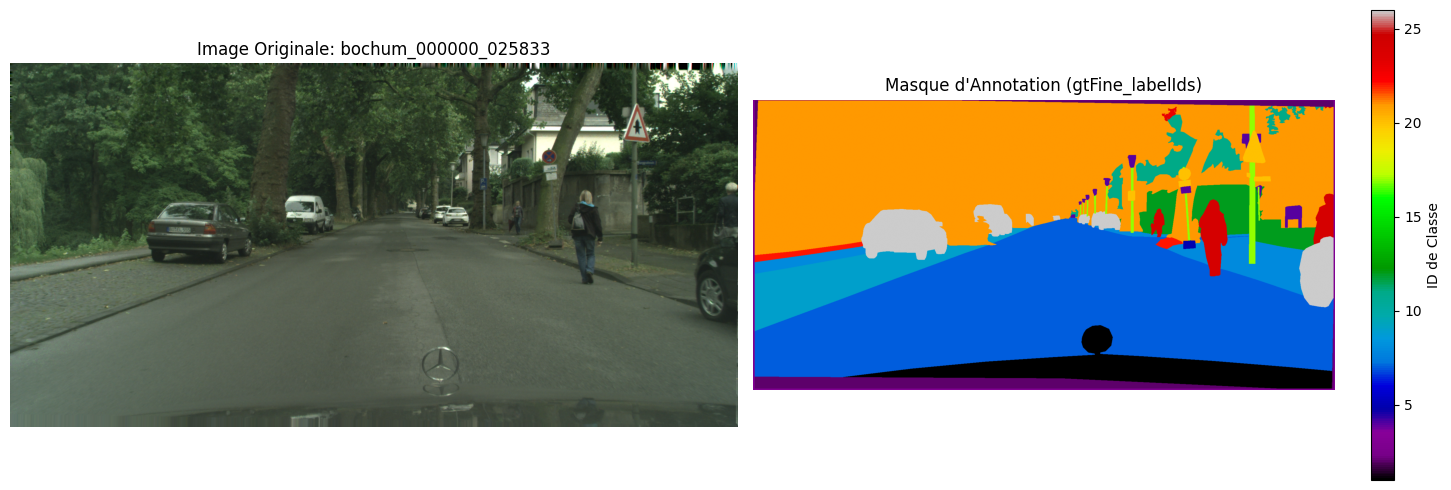

In [11]:
# CELLULE DE VISUALISATION DES IMAGES ET MASQUES

import cv2 # OpenCV pour la lecture et la manipulation d'images
import matplotlib.pyplot as plt # Pour l'affichage des images
import numpy as np # Pour les opérations numériques, notamment sur les tableaux (images)
import os # Pour les opérations sur les chemins de fichiers

# Les variables IMG_TRAIN_DIR, MASK_TRAIN_DIR etc. sont supposées
# être définies par la cellule de configuration des chemins précédente.

try:
    # Vérifier si les dossiers d'entraînement contiennent des données
    if not os.listdir(IMG_TRAIN_DIR_FULL):
        raise FileNotFoundError(f"Le dossier d'images d'entraînement {IMG_TRAIN_DIR_FULL} est vide ou ne contient pas de sous-dossiers de villes.")

    first_city_in_train_img = os.listdir(IMG_TRAIN_DIR_FULL)[0]

    path_to_city_images = os.path.join(IMG_TRAIN_DIR_FULL, first_city_in_train_img)
    if not os.listdir(path_to_city_images):
        raise FileNotFoundError(f"Le dossier de la ville {path_to_city_images} pour les images d'entraînement est vide.")

    # Sélectionner dynamiquement un fichier image exemple
    example_image_file_in_city = os.listdir(path_to_city_images)[0]
    # Extraire le nom de base du fichier (sans extension et suffixe _leftImg8bit)
    example_image_name_base = example_image_file_in_city.replace('_leftImg8bit.png', '')

    # Construire les chemins complets pour l'image et son masque d'annotation
    img_path = os.path.join(IMG_TRAIN_DIR_FULL, first_city_in_train_img, f'{example_image_name_base}_leftImg8bit.png')
    mask_path_labelIds = os.path.join(MASK_TRAIN_DIR_FULL, first_city_in_train_img, f'{example_image_name_base}_gtFine_labelIds.png')

    print(f"Tentative de chargement de l'image : {img_path}")
    print(f"Tentative de chargement du masque (labelIds) : {mask_path_labelIds}")

    # Vérifier l'existence des fichiers avant de tenter de les lire
    if os.path.exists(img_path) and os.path.exists(mask_path_labelIds):
        # Lire l'image avec OpenCV
        img = cv2.imread(img_path)
        # OpenCV lit les images en format BGR (Bleu, Vert, Rouge) par défaut.
        # Matplotlib s'attend à du RGB (Rouge, Vert, Bleu) pour un affichage correct des couleurs.
        # Nous convertissons donc l'ordre des canaux de couleurs.
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

        # Lire le masque d'annotation.
        # cv2.IMREAD_UNCHANGED est crucial ici car il assure que le masque est lu
        # tel quel, sans conversion de type ou de nombre de canaux, préservant les ID de classe.
        mask_labelIds = cv2.imread(mask_path_labelIds, cv2.IMREAD_UNCHANGED)

        print(f"\nDimension de l'image : {img.shape}") # Devrait être (hauteur, largeur, 3)
        print(f"Dimension du masque (labelIds) : {mask_labelIds.shape}") # Devrait être (hauteur, largeur)
        print(f"Type de données du masque : {mask_labelIds.dtype}") # Devrait être uint8 pour les ID de classe Cityscapes

        # Analyser les valeurs présentes dans le masque
        unique_ids = np.unique(mask_labelIds)
        print(f"Valeurs min/max dans le masque : {mask_labelIds.min()}/{mask_labelIds.max()}")
        print(f"Valeurs uniques dans le masque labelIds de '{example_image_name_base}': {unique_ids}")
        print(f"Nombre de valeurs uniques : {len(unique_ids)}")

        # Affichage de l'image et du masque
        plt.figure(figsize=(15, 5)) # Taille de la figure pour l'affichage

        plt.subplot(1, 2, 1) # Figure avec 1 ligne, 2 colonnes, ceci est le 1er subplot
        plt.imshow(img)
        plt.title(f'Image Originale: {example_image_name_base}')
        plt.axis('off') # Masquer les axes

        plt.subplot(1, 2, 2) # Ceci est le 2ème subplot
        # 'nipy_spectral' est un colormap qui peut aider à distinguer différentes valeurs numériques.
        # Vous pouvez en essayer d'autres (ex: 'viridis', 'jet', 'tab20').
        plt.imshow(mask_labelIds, cmap='nipy_spectral')
        plt.title(f'Masque d\'Annotation (gtFine_labelIds)')
        plt.colorbar(label='ID de Classe') # Ajoute une légende pour les couleurs/valeurs
        plt.axis('off') # Masquer les axes

        plt.tight_layout() # Ajuste automatiquement les subplots pour un meilleur rendu
        plt.show() # Affiche la figure
    else:
        print("ERREUR : Un des fichiers exemples (image ou masque labelIds) n'a pas été trouvé.")
        if not os.path.exists(img_path): print(f"Image non trouvée à l'emplacement : {img_path}")
        if not os.path.exists(mask_path_labelIds): print(f"Masque labelIds non trouvé à l'emplacement : {mask_path_labelIds}")

except FileNotFoundError as e:
    print(f"ERREUR lors de la recherche de fichiers : {e}")
    print("Veuillez vérifier que les dossiers d'entraînement/validation dans votre sous-ensemble contiennent bien des sous-dossiers de villes, et que ces derniers contiennent des images/masques.")
except IndexError:
    print("ERREUR : Impossible de lister des fichiers dans les dossiers d'images/masques.")
    print("Cela peut se produire si les dossiers de villes sont vides ou si la structure du dataset n'est pas celle attendue.")
except Exception as e:
    print(f"Une erreur inattendue est survenue lors de la visualisation : {e}")

L'exécution de la cellule précédente a permis de charger et visualiser avec succès une image du sous-ensemble Cityscapes et son masque d'annotation `_gtFine_labelIds.png`.

**Observations Clés :**
- **Dimensions Confirmées :** L'image (1024x2048x3) et le masque (1024x2048) ont les dimensions attendues.
- **Type de Données du Masque :** `uint8`, ce qui est correct pour les ID de classe.
- **Contenu du Masque :** Pour l'échantillon visualisé, les ID de classe varient de 0 à 33, avec **16 classes uniques** présentes.

Ces résultats confirment que nous accédons correctement aux données brutes. La présence de multiples ID de classes (jusqu'à 34 possibles au total dans le dataset) dans les masques `_labelIds.png` est la base pour notre tâche de segmentation. La prochaine étape logique impliquerait le mapping de ces classes fines vers les 8 catégories cibles du projet, mais avant cela, nous allons configurer notre outil de suivi d'expériences, MLflow.

### 0.4 Initialisation de MLflow avec Serveur de Tracking Distant via ngrok

Pour suivre et gérer nos expérimentations de modèles de manière robuste et persistante, nous allons maintenant configurer **MLflow**. Au lieu d'utiliser le stockage local temporaire de Colab, nous mettrons en place un **serveur de tracking MLflow accessible à distance** :
1.  Le **serveur MLflow** tournera dans notre environnement Colab.
2.  Ses données (métadonnées et artefacts des expériences) seront stockées de manière **persistante sur Google Drive**.
3.  **ngrok** créera un tunnel public sécurisé vers ce serveur, nous donnant une URL pour accéder à l'interface utilisateur (UI) de MLflow depuis n'importe quel navigateur. Le token d'authentification ngrok (`NGROK_AUTH_TOKEN`) est requis et doit être configuré dans les secrets Colab.

La cellule suivante installe les dépendances nécessaires, lance le serveur MLflow, le connecte à ngrok, et effectue un test de logging pour valider la configuration.

In [12]:
# CELLULE POUR LANCER MLFLOW SERVER AVEC NGROK (VERSION SIMPLIFIÉE)

import mlflow
import os
from google.colab import userdata, drive
import subprocess
import time
from pyngrok import ngrok, conf

# --- 1. Configuration ---
DRIVE_MLFLOW_PARENT_DIR = '/content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent' # Adaptez
MLFLOW_BACKEND_STORE_URI = f"sqlite:///{os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'mlflow.db')}"
MLFLOW_DEFAULT_ARTIFACT_ROOT = os.path.join(DRIVE_MLFLOW_PARENT_DIR, 'artifacts')
MLFLOW_PORT = 5000

os.makedirs(os.path.dirname(MLFLOW_BACKEND_STORE_URI.replace("sqlite:///", "")), exist_ok=True)
os.makedirs(MLFLOW_DEFAULT_ARTIFACT_ROOT, exist_ok=True)
print(f"Données MLflow seront stockées dans : {DRIVE_MLFLOW_PARENT_DIR}")

# --- 2. ngrok ---
try:
    NGROK_AUTH_TOKEN = userdata.get('NGROK_AUTH_TOKEN')
    if not NGROK_AUTH_TOKEN: raise ValueError("Token ngrok (NGROK_AUTH_TOKEN) manquant dans les secrets.")
    conf.get_default().auth_token = NGROK_AUTH_TOKEN
    # Arrêter les tunnels précédents pour éviter les conflits
    try: ngrok.kill()
    except: pass # Ignorer si aucun tunnel n'est actif
    print("Configuration ngrok OK.")
except Exception as e:
    print(f"ERREUR ngrok config : {e}")
    raise

# --- 3. Serveur MLflow ---
# S'assurer d'être dans un répertoire approprié
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
if os.path.exists(GIT_REPO_PATH_IN_COLAB): os.chdir(GIT_REPO_PATH_IN_COLAB)
else: os.chdir('/content/')

print(f"Lancement du serveur MLflow depuis {os.getcwd()}...")
# Tuer les instances précédentes
os.system("pkill -f 'mlflow server'")
time.sleep(1)

mlflow_server_command = [
    "mlflow", "server",
    "--backend-store-uri", MLFLOW_BACKEND_STORE_URI,
    "--default-artifact-root", MLFLOW_DEFAULT_ARTIFACT_ROOT,
    "--host", "0.0.0.0", "--port", str(MLFLOW_PORT)
]
# Lance le serveur en arrière-plan, redirige stdout/stderr vers /dev/null pour un output propre
mlflow_server_process = subprocess.Popen(mlflow_server_command, stdout=subprocess.DEVNULL, stderr=subprocess.DEVNULL)
print(f"Serveur MLflow démarré (PID: {mlflow_server_process.pid}). Attente (5s)...")
time.sleep(5) # Laisser le temps de démarrer

if mlflow_server_process.poll() is not None:
    raise RuntimeError("Échec du démarrage du serveur MLflow. Vérifiez la configuration.")
print("Serveur MLflow semble opérationnel.")

# --- 4. Exposer avec ngrok ---
try:
    public_url = ngrok.connect(MLFLOW_PORT, "http").public_url
    print(f"✅ UI MLflow accessible publiquement à : {public_url}")
except Exception as e:
    print(f"ERREUR lancement ngrok tunnel : {e}")
    mlflow_server_process.terminate(); mlflow_server_process.wait() # Tuer le serveur si ngrok échoue
    raise

# --- 5. Configurer et Tester MLflow Client ---
mlflow.set_tracking_uri(f"http://localhost:{MLFLOW_PORT}") # Le client logue vers le serveur local, ngrok fait le pont
print(f"URI de tracking MLflow configurée sur : {mlflow.get_tracking_uri()}")
'''
try:
    with mlflow.start_run(run_name="TestServeurDistantSimplifié"):
        mlflow.log_param("test_param_simple", 123)
        mlflow.log_metric("test_metric_simple", 0.123)
    print(f"🎉 Run de test MLflow ('TestServeurDistantSimplifié') logguée avec succès sur {public_url}")
except Exception as e:
    print(f"ERREUR lors du test de logging MLflow : {e}")
'''
# Conservez la variable `mlflow_server_process` si vous voulez l'arrêter proprement plus tard
# et `public_url` pour la déconnexion ngrok.

Données MLflow seront stockées dans : /content/drive/MyDrive/Colab Notebooks/OC/P8/mlflow_tracking_persistent
Configuration ngrok OK.
Lancement du serveur MLflow depuis /content/OC-autonomous-vehicle-segmentation...
Serveur MLflow démarré (PID: 895). Attente (5s)...
Serveur MLflow semble opérationnel.
✅ UI MLflow accessible publiquement à : https://c450-34-19-36-254.ngrok-free.app
URI de tracking MLflow configurée sur : http://localhost:5000


'\ntry:\n    with mlflow.start_run(run_name="TestServeurDistantSimplifié"):\n        mlflow.log_param("test_param_simple", 123)\n        mlflow.log_metric("test_metric_simple", 0.123)\n    print(f"🎉 Run de test MLflow (\'TestServeurDistantSimplifié\') logguée avec succès sur {public_url}")\nexcept Exception as e:\n    print(f"ERREUR lors du test de logging MLflow : {e}")\n'

In [13]:
'''
# Cellule pour arrêter ngrok et le serveur MLflow (exécuter quand vous avez fini)
from pyngrok import ngrok

print("Arrêt des tunnels ngrok...")
try:
    ngrok.kill() # Tue tous les tunnels ngrok de cette session
    print("Tunnels ngrok arrêtés.")
except Exception as e:
    print(f"Erreur lors de l'arrêt de ngrok : {e}")

# Tuer le processus serveur MLflow (si vous avez stocké son PID)
# Si vous n'avez pas le PID, 'pkill' est une option plus brutale mais fonctionne souvent en Colab
print("\nTentative d'arrêt du serveur MLflow...")
os.system("pkill -f 'mlflow server'")
print("Commande pkill pour le serveur MLflow envoyée.")
# Note: mlflow_server_process.terminate() ne fonctionnera que si la variable
# mlflow_server_process de la cellule de démarrage est toujours accessible et que le processus est le même.
'''

'\n# Cellule pour arrêter ngrok et le serveur MLflow (exécuter quand vous avez fini)\nfrom pyngrok import ngrok\n\nprint("Arrêt des tunnels ngrok...")\ntry:\n    ngrok.kill() # Tue tous les tunnels ngrok de cette session\n    print("Tunnels ngrok arrêtés.")\nexcept Exception as e:\n    print(f"Erreur lors de l\'arrêt de ngrok : {e}")\n\n# Tuer le processus serveur MLflow (si vous avez stocké son PID)\n# Si vous n\'avez pas le PID, \'pkill\' est une option plus brutale mais fonctionne souvent en Colab\nprint("\nTentative d\'arrêt du serveur MLflow...")\nos.system("pkill -f \'mlflow server\'")\nprint("Commande pkill pour le serveur MLflow envoyée.")\n# Note: mlflow_server_process.terminate() ne fonctionnera que si la variable\n# mlflow_server_process de la cellule de démarrage est toujours accessible et que le processus est le même.\n'

## 1.0 Préparation du Générateur de Données et Conception des Modèles

### 1.1 Préparation du Générateur de Données

Avec la configuration initiale et l'outil de suivi d'expériences (MLflow) en place, nous entrons maintenant dans la **Phase 1**. L'objectif principal ici est de préparer nos données Cityscapes pour qu'elles puissent être efficacement utilisées par nos modèles de segmentation d'images. Cela implique deux étapes majeures :

1.  **Création d'un Générateur de Données (Data Generator)** : Nous allons développer une classe Python personnalisée, héritant de `tf.keras.utils.Sequence`. Ce générateur sera responsable du chargement des images et des masques, du **mapping des ~34 classes fines de Cityscapes vers nos 8 catégories cibles**, du redimensionnement, de la normalisation, de l'augmentation des données, et de la fourniture des données par lots (batches) au modèle.
2.  **Conception Initiale des Modèles de Segmentation** : Parallèlement, nous définirons les architectures de base pour nos modèles de segmentation (par exemple, un U-Net simple et un U-Net avec un encodeur pré-entraîné), ainsi que les métriques d'évaluation et les fonctions de perte appropriées.

Commençons par la tâche la plus critique : le **développement du générateur de données**, en nous concentrant d'abord sur le chargement des données et le mapping des classes.

#### 1.1.1 Définition du Mapping des Classes : des 34 Classes Cityscapes aux 8 Catégories Cibles

La première étape cruciale dans la préparation de nos données est de traduire les annotations fines fournies par Cityscapes (environ 34 classes distinctes, identifiées par des `id` spécifiques) vers les **8 catégories principales** requises par l'énoncé du projet. Ces 8 catégories sont : `flat`, `human`, `vehicle`, `construction`, `object`, `nature`, `sky`, et `void`.

Pour réaliser ce mapping de manière propre et réutilisable, nous avons :
1.  Créé un fichier Python (`cityscapes_labels.py`) contenant les définitions officielles des labels Cityscapes (nom, `id`, `category`, `ignoreInEval`, etc.). Ce fichier est stocké sur Google Drive et sera versionné avec notre projet.
2.  Importé ces définitions dans notre notebook.
3.  Défini un dictionnaire de correspondance (`category_mapping_to_new_id`) qui associe chaque nom de catégorie Cityscapes pertinent à un nouvel ID cible (de 0 à 7 pour nos 8 catégories).
4.  Généré un dictionnaire final, `id_to_target_id_mapping`, qui mappe chaque `id` original de Cityscapes vers l'un de nos nouveaux ID cibles (0-7) si la classe Cityscapes appartient à l'une de nos 8 catégories principales.

In [14]:
# CELLULE POUR DÉFINIR LE MAPPING DES CLASSES
# VERS 8 CATÉGORIES CIBLES (0-7), OÙ LA CLASSE 7 EST 'void'/'ignore'

import numpy as np
import os
import sys

# --- Assurer l'importation de labels_cityscapes ---
# (Même logique d'importation que précédemment)
module_dir_on_drive = '/content/drive/MyDrive/Colab Notebooks/OC/P8/src' # ADAPTEZ SI VOTRE cityscapes_labels.py EST AILLEURS
if module_dir_on_drive not in sys.path:
    sys.path.append(module_dir_on_drive)
    print(f"Ajouté '{module_dir_on_drive}' à sys.path pour l'importation.")

try:
    from cityscapes_labels import labels as labels_cityscapes
    print("Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.")
except ImportError as e:
    print(f"ERREUR d'importation : {e}")
    raise

# --- Définition des 8 Catégories Cibles et de leur ID (0 à 7) ---
# La classe 'void' (ID 7) regroupera tout ce qui n'est pas les 7 autres ou ce qui est à ignorer.
category_mapping_to_new_id = {
    'flat': 0,
    'human': 1,
    'vehicle': 2,
    'construction': 3,
    'object': 4,
    'nature': 5,
    'sky': 6,
    'void': 7  # Notre 8ème classe "fourre-tout" / "ignore"
}
NUM_TARGET_CLASSES = 8 # Nous aurons toujours 8 classes en sortie du modèle

# --- Création du dictionnaire de mapping: cityscapes_id -> new_target_id (0-7) ---
id_to_target_id_mapping_simplified = {}

# L'ID de notre classe 'void' (où tout ce qui est non pertinent ou ignoré sera mappé)
VOID_TARGET_ID = category_mapping_to_new_id['void'] # C'est 7

for label_info in labels_cityscapes:
    cityscapes_id = label_info.id
    cityscapes_category_name = label_info.category
    ignore_in_eval_flag = label_info.ignoreInEval
    cityscapes_label_name = label_info.name # Utile pour le débogage

    # Cas 1: L'ID Cityscapes est -1 (license plate) ou la classe est explicitement à ignorer
    # OU si la catégorie de la classe n'est pas une de nos 7 classes principales actives.
    # Toutes ces situations sont mappées vers notre classe VOID_TARGET_ID (7).

    if cityscapes_id == -1: # license plate
        id_to_target_id_mapping_simplified[cityscapes_id] = VOID_TARGET_ID
    elif ignore_in_eval_flag: # Ex: 'parking', 'rail track', 'unlabeled', 'ego vehicle', 'ground'
        id_to_target_id_mapping_simplified[cityscapes_id] = VOID_TARGET_ID
    elif cityscapes_category_name in category_mapping_to_new_id:
        # La catégorie est l'une de nos 8 (y compris 'void' de Cityscapes qui va aussi à notre 'void')
        id_to_target_id_mapping_simplified[cityscapes_id] = category_mapping_to_new_id[cityscapes_category_name]
    else:
        # Ce cas ne devrait pas arriver si toutes les catégories de Cityscapes sont couvertes
        # (flat, human, vehicle, construction, object, nature, sky, void).
        # Par sécurité, mapper à notre VOID_TARGET_ID.
        print(f"AVERTISSEMENT: Catégorie Cityscapes inattendue '{cityscapes_category_name}' pour la classe '{cityscapes_label_name}' (ID: {cityscapes_id}). Mappée à VOID ({VOID_TARGET_ID}).")
        id_to_target_id_mapping_simplified[cityscapes_id] = VOID_TARGET_ID

# Afficher le mapping pour vérification
print("\n--- Mapping SIMPLIFIÉ de cityscapes_id vers new_target_id (0-7) ---")
all_cs_ids = sorted(list(set([lbl.id for lbl in labels_cityscapes])))

for cs_id in all_cs_ids:
    target_id = id_to_target_id_mapping_simplified.get(cs_id, "ERREUR DE MAPPING !")

    original_label_name = "N/A"
    original_category = "N/A"
    ignore_flag = "N/A"
    for lbl in labels_cityscapes:
        if lbl.id == cs_id:
            original_label_name = lbl.name
            original_category = lbl.category
            ignore_flag = lbl.ignoreInEval
            break
    print(f"Cityscapes ID: {cs_id:>2} (Nom: {original_label_name:<22}, Cat: {original_category:<14}, IgnoreEval: {str(ignore_flag):<5})  => Mappé à ID Cible: {target_id}")

print(f"\nDictionnaire de mapping simplifié ('id_to_target_id_mapping_simplified') contient {len(id_to_target_id_mapping_simplified)} entrées.")
print(f"Les ID cibles uniques sont : {sorted(list(set(id_to_target_id_mapping_simplified.values())))}") # Devrait être [0, 1, 2, 3, 4, 5, 6, 7]

Importation de 'labels_cityscapes' depuis 'cityscapes_labels.py' réussie.

--- Mapping SIMPLIFIÉ de cityscapes_id vers new_target_id (0-7) ---
Cityscapes ID: -1 (Nom: license plate         , Cat: vehicle       , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  0 (Nom: unlabeled             , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  1 (Nom: ego vehicle           , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  2 (Nom: rectification border  , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  3 (Nom: out of roi            , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  4 (Nom: static                , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  5 (Nom: dynamic               , Cat: void          , IgnoreEval: True )  => Mappé à ID Cible: 7
Cityscapes ID:  6 (Nom: ground                , Cat: void          , Igno

Le dictionnaire final contient 35 entrées, couvrant tous les ID Cityscapes de -1 à 33. Ce mapping est maintenant prêt à être utilisé dans notre générateur de données pour transformer les masques d'annotation bruts.

#### 1.1.2 Définition de la Classe Générateur de Données (`CityscapesDataGenerator`)

Nous allons maintenant définir la classe `CityscapesDataGenerator` qui héritera de `tf.keras.utils.Sequence`. Cette classe sera responsable de :
- Charger les paires image/masque.
- Appliquer le `id_to_target_id_mapping` pour convertir les masques vers nos 8 catégories cibles.
- Redimensionner les images et les masques à une taille fixe.
- Normaliser les images.
- (Optionnellement) Appliquer des techniques d'augmentation de données.
- Fournir les données prétraitées par lots (batches) au modèle Keras.

In [15]:
# CELLULE POUR DÉFINIR LA FONCTION UTILITAIRE DE COLLECTE DES CHEMINS DE FICHIERS

def get_cityscapes_filepaths(image_base_dir, mask_base_dir,
                             target_cities=None,
                             image_suffix='_leftImg8bit.png',
                             mask_suffix='_gtFine_labelIds.png'):
    image_paths = []
    mask_paths = []

    if not os.path.isdir(image_base_dir):
        return image_paths, mask_paths
    if not os.path.isdir(mask_base_dir):
        return image_paths, mask_paths

    # Déterminer les villes à parcourir
    available_cities = sorted(os.listdir(image_base_dir))
    cities_to_scan = available_cities
    if target_cities is not None:
        # Filtrer pour ne garder que les target_cities qui existent réellement
        cities_to_scan = [city for city in available_cities if city in target_cities]
        if not cities_to_scan:
            print(f"AVERTISSEMENT : Aucune des villes cibles {target_cities} n'a été trouvée dans {image_base_dir}.")
            return image_paths, mask_paths
        print(f"Scan limité aux villes cibles : {cities_to_scan}")


    for city_folder_name in cities_to_scan: # Utilise maintenant la liste filtrée ou complète
        city_image_dir_abs = os.path.join(image_base_dir, city_folder_name)
        city_mask_dir_abs = os.path.join(mask_base_dir, city_folder_name)

        if os.path.isdir(city_image_dir_abs) and os.path.isdir(city_mask_dir_abs):
            for img_file_name in sorted(os.listdir(city_image_dir_abs)):
                if img_file_name.endswith(image_suffix):
                    base_name = img_file_name.replace(image_suffix, '')
                    full_img_path = os.path.join(city_image_dir_abs, img_file_name)
                    mask_file_name_expected = f"{base_name}{mask_suffix}"
                    full_mask_path_expected = os.path.join(city_mask_dir_abs, mask_file_name_expected)

                    if os.path.isfile(full_mask_path_expected):
                        image_paths.append(full_img_path)
                        mask_paths.append(full_mask_path_expected)

    if not image_paths:
        print(f"Aucune paire image/masque trouvée. Vérifiez les chemins de base et la structure des dossiers:\n"
              f"  Dossier Images: {image_base_dir}\n"
              f"  Dossier Masques: {mask_base_dir}\n"
              f"  Suffixe Image Attendu: {image_suffix}\n"
              f"  Suffixe Masque Attendu: {mask_suffix}")

    return image_paths, mask_paths

# --- TEST DE LA FONCTION UTILITAIRE ---
# Assurez-vous que les variables globales IMG_TRAIN_DIR, MASK_TRAIN_DIR, IMG_VAL_DIR, MASK_VAL_DIR
# sont bien définies et pointent vers les bons dossiers de votre sous-ensemble sur Drive.

print("--- Test de get_cityscapes_filepaths pour l'ensemble d'entraînement ---")
# Ces variables (IMG_TRAIN_DIR, etc.) doivent être définies par votre cellule de configuration des chemins de données
if 'IMG_TRAIN_DIR_FULL' in globals() and 'MASK_TRAIN_DIR_FULL' in globals():
    train_image_fnames, train_mask_fnames = get_cityscapes_filepaths(IMG_TRAIN_DIR_FULL, MASK_TRAIN_DIR_FULL)
    print(f"Trouvé {len(train_image_fnames)} images et {len(train_mask_fnames)} masques pour l'entraînement.")
    if train_image_fnames: # Afficher les premiers pour vérification
        print("Exemples de chemins d'images d'entraînement:")
        for p in train_image_fnames[:3]: print(f"  {p}")
        print("Exemples de chemins de masques d'entraînement:")
        for p in train_mask_fnames[:3]: print(f"  {p}")
else:
    print("Variables IMG_TRAIN_DIR ou MASK_TRAIN_DIR non définies. Test sauté.")

print("\n--- Test de get_cityscapes_filepaths pour l'ensemble de validation ---")
if 'IMG_VAL_DIR_FULL' in globals() and 'MASK_VAL_DIR_FULL' in globals():
    val_image_fnames, val_mask_fnames = get_cityscapes_filepaths(IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL)
    print(f"Trouvé {len(val_image_fnames)} images et {len(val_mask_fnames)} masques pour la validation.")
    if val_image_fnames: # Afficher les premiers pour vérification
        print("Exemples de chemins d'images de validation:")
        for p in val_image_fnames[:3]: print(f"  {p}")
        print("Exemples de chemins de masques de validation:")
        for p in val_mask_fnames[:3]: print(f"  {p}")
else:
    print("Variables IMG_VAL_DIR ou MASK_VAL_DIR non définies. Test sauté.")

--- Test de get_cityscapes_filepaths pour l'ensemble d'entraînement ---
Trouvé 2975 images et 2975 masques pour l'entraînement.
Exemples de chemins d'images d'entraînement:
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000000_000019_leftImg8bit.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000001_000019_leftImg8bit.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_leftImg8bit_trainvaltest/leftImg8bit/train/aachen/aachen_000002_000019_leftImg8bit.png
Exemples de chemins de masques d'entraînement:
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000000_000019_gtFine_labelIds.png
  /content/drive/MyDrive/Colab Notebooks/OC/P8/data/P8_Cityscapes_gtFine_trainvaltest/gtFine/train/aachen/aachen_000001_000019_gtFine_labelIds.png
  /content/drive/MyDrive/Co

In [16]:
!pip install albumentations -q

In [17]:
# CELLULE POUR LA CLASSE CityscapesDataGenerator

import tensorflow as tf
import numpy as np
import cv2
import os
import math

# Les variables globales comme NUM_TARGET_CLASSES (8) et
# id_to_target_id_mapping_simplified (notre nouveau dictionnaire de mapping)
# sont supposées être définies dans des cellules précédentes.

class CityscapesDataGenerator(tf.keras.utils.Sequence):
    """
    Générateur de données simplifié pour Cityscapes.
    Tous les pixels sont mappés à l'une des NUM_TARGET_CLASSES (0 à NUM_TARGET_CLASSES-1).
    """
    def __init__(self,
                 image_filenames_list,
                 mask_filenames_list,
                 id_to_target_mapping, # C'est notre id_to_target_id_mapping_simplified
                 batch_size,
                 target_img_size,
                 num_target_classes,   # C'est notre NUM_TARGET_CLASSES (8)
                 shuffle=True,
                 augmentations=None):

        assert len(image_filenames_list) == len(mask_filenames_list), \
            "Le nombre d'images et de masques doit être identique."
        assert len(image_filenames_list) > 0, \
            "La liste des fichiers images ne peut pas être vide."

        self.image_filenames = image_filenames_list
        self.mask_filenames = mask_filenames_list
        self.id_to_target_mapping = id_to_target_mapping # Le mapping simplifié
        self.batch_size = batch_size
        self.target_img_size = target_img_size
        self.num_target_classes = num_target_classes # Devrait être 8

        self.shuffle = shuffle
        self.augmentations = augmentations

        self.indexes = np.arange(len(self.image_filenames))
        if self.shuffle:
            self.on_epoch_end()

        print(f"Générateur (simplifié) initialisé avec {len(self.image_filenames)} paires image/masque.")
        if len(self.image_filenames) < self.batch_size:
            print(f"AVERTISSEMENT : Nb échantillons ({len(self.image_filenames)}) < batch_size ({self.batch_size}).")

    def __len__(self):
        if len(self.image_filenames) == 0: return 0
        return math.ceil(len(self.image_filenames) / self.batch_size)

    def _apply_class_mapping(self, mask_raw):
        """
        Applique le mapping des ID Cityscapes aux ID cibles (0 à NUM_TARGET_CLASSES-1).
        """
        # Initialiser avec une valeur qui sera écrasée, ou une classe par défaut si certains ID manquaient
        # Mais notre mapping simplifié devrait couvrir tous les ID Cityscapes.
        # Pour la robustesse, on pourrait initialiser avec la classe 'void' (ID 7).
        # Cela suppose que VOID_TARGET_ID est accessible ou connu (ex: self.num_target_classes - 1)
        void_class_id = self.num_target_classes - 1 # Si la dernière classe est 'void'
        mapped_mask = np.full(mask_raw.shape, void_class_id, dtype=np.uint8)

        for cityscapes_id, target_id in self.id_to_target_mapping.items():
            # target_id est maintenant toujours entre 0 et self.num_target_classes - 1
            mapped_mask[mask_raw == cityscapes_id] = target_id
        return mapped_mask

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        batch_image_filenames = [self.image_filenames[i] for i in batch_indexes]
        batch_mask_filenames = [self.mask_filenames[i] for i in batch_indexes]

        X_batch = np.zeros((len(batch_image_filenames), self.target_img_size[0], self.target_img_size[1], 3), dtype=np.float32)
        # y_batch contiendra maintenant des ID de 0 à NUM_TARGET_CLASSES-1.
        # Peut être initialisé avec des zéros ou l'ID de la classe 'void'.
        void_class_id = self.num_target_classes - 1
        y_batch = np.full((len(batch_mask_filenames), self.target_img_size[0], self.target_img_size[1]),
                          fill_value=void_class_id, dtype=np.uint8) # ou np.zeros(..., dtype=np.uint8)

        for i, (img_path, mask_path) in enumerate(zip(batch_image_filenames, batch_mask_filenames)):
            try:
                img = cv2.imread(img_path)
                if img is None: continue
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

                mask_raw = cv2.imread(mask_path, cv2.IMREAD_UNCHANGED)
                if mask_raw is None: continue

                mapped_mask = self._apply_class_mapping(mask_raw) # Produit des ID de 0 à 7

                current_img = img
                current_mask = mapped_mask

                # --- DEBUG POINT 1 ---
                # print(f"DEBUG B1: Unique IDs dans mapped_mask (avant aug): {np.unique(current_mask)}")

                if self.augmentations:
                    augmented = self.augmentations(image=current_img, mask=current_mask)
                    current_img = augmented['image']
                    current_mask = augmented['mask']
                    # --- DEBUG POINT 2 ---
                    print(f"DEBUG B2: Unique IDs dans current_mask (APRES aug): {np.unique(current_mask)}")


                target_dsize = (self.target_img_size[1], self.target_img_size[0])
                img_final = cv2.resize(current_img, target_dsize, interpolation=cv2.INTER_LINEAR)
                mask_final = cv2.resize(current_mask, target_dsize, interpolation=cv2.INTER_NEAREST)

                # Pansement pour l'erreur de SparseCategoricalCrossentropy
                # Assurer qu'il n'y a que des valeurs 0-7 dans le masque final passé à la loss
                # en mappant toute autre valeur (comme un 255 errant) à la classe 'void' (7)
                cleaned_mask_final = np.where(
                    (mask_final >= 0) & (mask_final < self.num_target_classes),
                    mask_final,
                    self.num_target_classes - 1 # Mettre à la classe 'void' (7)
                )
                # Ou plus brutalement si on est sûr que seul 255 pose problème :
                # cleaned_mask_final = np.where(mask_final == 255, self.num_target_classes - 1, mask_final)


                X_batch[i] = img_final / 255.0
                y_batch[i] = cleaned_mask_final

            except Exception as e:
                print(f"ERREUR dans __getitem__ (simplifié) pour item {i} (img: {img_path}): {e}")
                continue

        return X_batch, y_batch.astype(np.int32)

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

#### 1.1.3 Instanciation des Générateurs de Données pour le Développement

Maintenant que la classe `CityscapesDataGenerator` est définie et que nous disposons de la fonction utilitaire `get_cityscapes_filepaths` pour collecter les chemins de fichiers, nous pouvons créer les instances de nos générateurs.

Pour la phase de développement et de prototypage rapide, nous allons travailler avec un **échantillon de villes** sélectionnées à partir des ensembles de données `train`, `val`, et `test` complets. La cellule suivante va :
1.  Définir les listes de villes cibles pour nos ensembles de développement (`DEV_TRAIN_CITIES`, `DEV_VAL_CITIES`, `DEV_TEST_CITIES`).
2.  Utiliser `get_cityscapes_filepaths` pour collecter les listes de fichiers images et masques correspondants à ces villes.
3.  Définir un pipeline d'augmentation de données (`aug_pipeline_train_dev`) qui sera appliqué uniquement au générateur d'entraînement.
4.  Instancier trois objets `CityscapesDataGenerator` :
    *   `train_generator_dev` : Pour l'entraînement, avec augmentation et mélange des données.
    *   `val_generator_dev` : Pour la validation, sans augmentation ni mélange.
    *   `test_generator_dev` : Pour le test, sans augmentation ni mélange.
5.  Effectuer un test rapide pour récupérer un batch du `train_generator_dev` et visualiser un échantillon afin de vérifier que tout fonctionne comme attendu (y compris les augmentations).

--- Collecte des fichiers pour l'ÉCHANTILLON DE DÉVELOPPEMENT (avec get_cityscapes_filepaths) ---
Scan limité aux villes cibles : ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Scan limité aux villes cibles : ['frankfurt', 'lindau']
Scan limité aux villes cibles : ['munster']
Dev Train: 2975 imgs des villes ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt', 'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena', 'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart', 'tubingen', 'ulm', 'weimar', 'zurich']
Dev Val: 326 imgs des villes ['frankfurt', 'lindau']
Dev Test: 174 imgs des villes ['munster']


<ipython-input-18-9d22b9381c4d>:39: UserWarning: Argument(s) 'mode, cval' are not valid for transform Affine
  A.Affine(


Pipeline d'augmentation (pour train_generator_dev) défini.

--- Instanciation des générateurs de DÉVELOPPEMENT (SIMPLIFIÉS) ---
Générateur (simplifié) initialisé avec 2975 paires image/masque.
train_generator_dev (avec augmentation) créé avec 744 batches.
Générateur (simplifié) initialisé avec 326 paires image/masque.
val_generator_dev (sans augmentation) créé avec 82 batches.
Générateur (simplifié) initialisé avec 174 paires image/masque.
test_generator_dev (sans augmentation) créé avec 44 batches.

Test de récupération d'un batch depuis train_generator_dev:
DEBUG B2: Unique IDs dans current_mask (APRES aug): [0 1 2 3 4 5 6 7]
DEBUG B2: Unique IDs dans current_mask (APRES aug): [0 1 2 3 4 5 6 7]
DEBUG B2: Unique IDs dans current_mask (APRES aug): [0 1 2 3 4 5 6 7]
DEBUG B2: Unique IDs dans current_mask (APRES aug): [0 1 2 3 4 5 6 7]
  Shape X_dev_batch: (4, 256, 512, 3)
  Shape y_dev_batch: (4, 256, 512)
  Valeurs uniques dans le premier masque de y_dev_batch: [0 1 2 3 4 5 6 7]


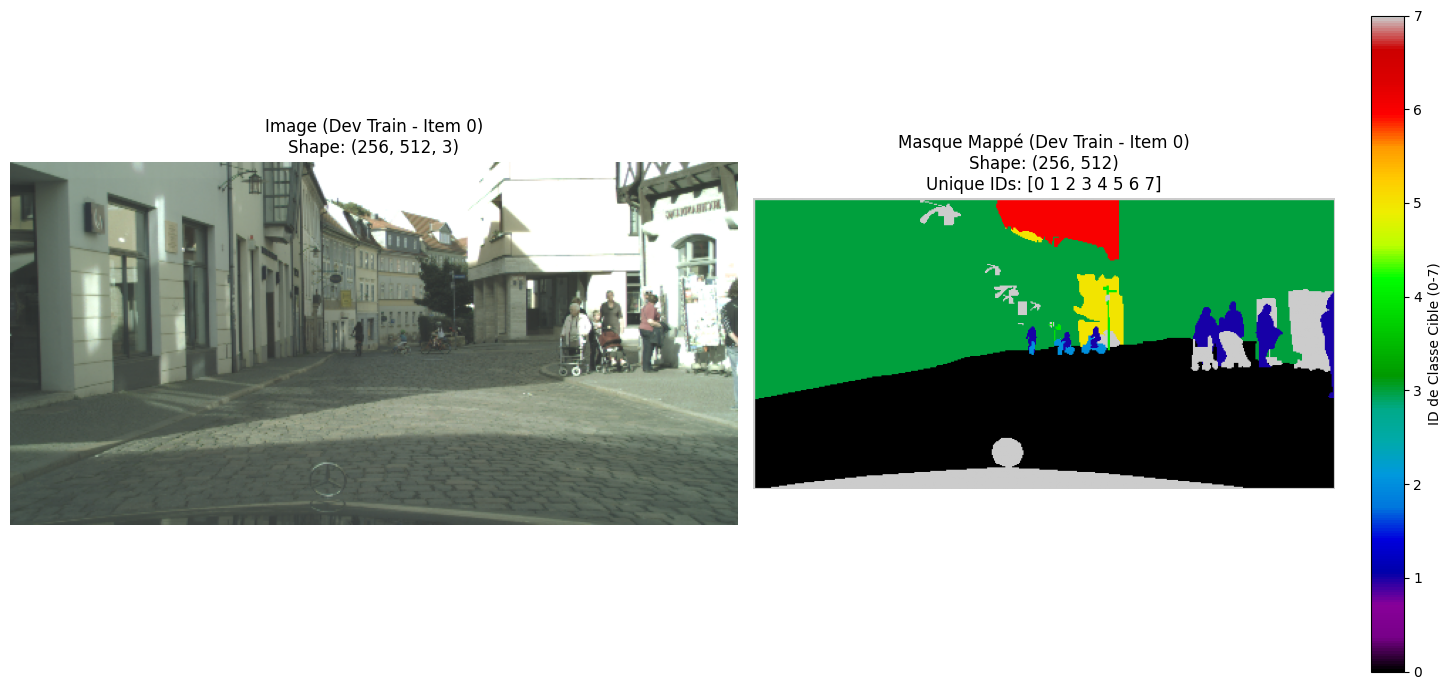

In [18]:
# CELLULE (MISE À JOUR) POUR INSTANCIER LES GÉNÉRATEURS DE DÉVELOPPEMENT SIMPLIFIÉS

# --- Définition des Villes pour l'Échantillon de Développement (identique à avant) ---
# (Assurez-vous que ces listes sont définies et correctes pour votre dataset)
DEV_TRAIN_CITIES = ['aachen', 'bochum', 'bremen', 'cologne', 'darmstadt',
                    'dusseldorf', 'erfurt', 'hamburg', 'hanover', 'jena',
                    'krefeld', 'monchengladbach', 'strasbourg', 'stuttgart',
                    'tubingen', 'ulm', 'weimar', 'zurich'
]
DEV_VAL_CITIES = ['frankfurt', 'lindau']
DEV_TEST_CITIES = ['munster']

print("--- Collecte des fichiers pour l'ÉCHANTILLON DE DÉVELOPPEMENT (avec get_cityscapes_filepaths) ---")
img_fnames_train_dev, mask_fnames_train_dev = get_cityscapes_filepaths(
    IMG_TRAIN_DIR_FULL, MASK_TRAIN_DIR_FULL, target_cities=DEV_TRAIN_CITIES
)
img_fnames_val_dev, mask_fnames_val_dev = get_cityscapes_filepaths(
    IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL, target_cities=DEV_VAL_CITIES
)
img_fnames_test_dev, mask_fnames_test_dev = get_cityscapes_filepaths(
    IMG_VAL_DIR_FULL, MASK_VAL_DIR_FULL, target_cities=DEV_TEST_CITIES
)
print(f"Dev Train: {len(img_fnames_train_dev)} imgs des villes {DEV_TRAIN_CITIES}")
print(f"Dev Val: {len(img_fnames_val_dev)} imgs des villes {DEV_VAL_CITIES}")
print(f"Dev Test: {len(img_fnames_test_dev)} imgs des villes {DEV_TEST_CITIES}")


# --- Paramètres pour les Générateurs de Développement (identique à avant) ---
BATCH_SIZE_DEV = 4
TARGET_IMG_HEIGHT_DEV = 256
TARGET_IMG_WIDTH_DEV = 512

# --- Définition du Pipeline d'Augmentation (identique à avant, ou votre dernière version) ---
import albumentations as A
import cv2
VOID_TARGET_ID = NUM_TARGET_CLASSES - 1 # qui est 7
aug_pipeline_train_dev = A.Compose([
    A.HorizontalFlip(p=0.5),
    A.Affine(
        scale={'x': (0.9, 1.1), 'y': (0.9, 1.1)},
        translate_percent={'x': (-0.0625, 0.0625), 'y': (-0.0625, 0.0625)},
        rotate=(-15, 15),
        p=0.7,
        interpolation=cv2.INTER_LINEAR,
        mask_interpolation=cv2.INTER_NEAREST,
        # border_mode=cv2.BORDER_REFLECT_101 # Bon choix
        # Si vous utilisez BORDER_CONSTANT, vous DEVEZ gérer mask_value:
        mode=cv2.BORDER_CONSTANT,
        cval=0,
        # Pour Affine, cval_mask n'est pas un param direct. Le masque sera paddé à 0.
        # Si 0 est 'flat', cela peut être problématique.
        # Préférez BORDER_REFLECT_101, ou si vous devez utiliser BORDER_CONSTANT,
        # soyez conscient que le padding du masque sera 0.
        # Si VOID_TARGET_ID est 0, c'est ok. Mais si VOID_TARGET_ID est 7 et flat est 0, c'est un problème.
        # Laissons border_mode=cv2.BORDER_REFLECT_101 pour l'instant pour éviter ce souci.
        border_mode=cv2.BORDER_REFLECT_101,
    ),
    A.RandomBrightnessContrast(brightness_limit=0.2, contrast_limit=0.2, p=0.5),
    A.GaussNoise(std_range=(0.02, 0.08), p=0.3) # Utiliser std_range si GaussNoise a été mis à jour
])
print("Pipeline d'augmentation (pour train_generator_dev) défini.")
# Si aug_pipeline_train_dev n'est pas redéfini ici, il utilisera la dernière définition.
# Assurez-vous que la version de aug_pipeline_train_dev que vous voulez utiliser est active.

print("\n--- Instanciation des générateurs de DÉVELOPPEMENT (SIMPLIFIÉS) ---")

# S'assurer que les variables globales sont bien celles que nous attendons
if 'id_to_target_id_mapping_simplified' not in globals():
    raise NameError("'id_to_target_id_mapping_simplified' n'est pas défini. Exécutez la cellule de mapping simplifiée.")
if 'NUM_TARGET_CLASSES' not in globals() or NUM_TARGET_CLASSES != 8:
    raise ValueError(f"NUM_TARGET_CLASSES doit être 8, actuellement : {globals().get('NUM_TARGET_CLASSES')}")

current_id_mapping = id_to_target_id_mapping_simplified

train_generator_dev = None
if img_fnames_train_dev:
    train_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_train_dev,
        mask_filenames_list=mask_fnames_train_dev,
        id_to_target_mapping=current_id_mapping, # Utilise le mapping simplifié
        batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES,       # Est 8
        # ignore_value n'est plus un paramètre
        shuffle=True,
        augmentations=aug_pipeline_train_dev # Passez votre pipeline d'augmentation défini
    )
    print(f"train_generator_dev (avec augmentation) créé avec {len(train_generator_dev)} batches.")
else:
    print("Aucun fichier pour train_generator_dev. Générateur non créé.")

val_generator_dev = None
# ... (instanciation similaire pour val_generator_dev et test_generator_dev, sans 'ignore_value' et avec augmentations=None)
if img_fnames_val_dev:
    val_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_val_dev,
        mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=current_id_mapping,
        batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES,
        shuffle=False,
        augmentations=None
    )
    print(f"val_generator_dev (sans augmentation) créé avec {len(val_generator_dev)} batches.")
else:
    print("Aucun fichier pour val_generator_dev. Générateur non créé.")

test_generator_dev = None
if img_fnames_test_dev:
    test_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev,
        mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=current_id_mapping,
        batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES,
        shuffle=False,
        augmentations=None
    )
    print(f"test_generator_dev (sans augmentation) créé avec {len(test_generator_dev)} batches.")
else:
    print("Aucun fichier pour test_generator_dev. Générateur non créé.")


# --- Test rapide d'un batch du générateur d'entraînement ---
if train_generator_dev and len(train_generator_dev) > 0:
    print("\nTest de récupération d'un batch depuis train_generator_dev:")
    X_dev_batch, y_dev_batch = train_generator_dev[0] # Devrait retourner seulement X, y
    print(f"  Shape X_dev_batch: {X_dev_batch.shape}")
    print(f"  Shape y_dev_batch: {y_dev_batch.shape}")
    unique_ids_in_mask = np.unique(y_dev_batch[0])
    print(f"  Valeurs uniques dans le premier masque de y_dev_batch: {unique_ids_in_mask}")
    # Vérifier que les valeurs sont bien entre 0 et NUM_TARGET_CLASSES - 1
    if np.any(unique_ids_in_mask >= NUM_TARGET_CLASSES) or np.any(unique_ids_in_mask < 0):
        print(f"  ATTENTION: Des valeurs inattendues sont présentes dans le masque mappé ! Plage attendue [0, {NUM_TARGET_CLASSES-1}]")

    # Visualisation (peut être réutilisée)
    import matplotlib.pyplot as plt
    plt.figure(figsize=(15, 7))
    # ... (code de visualisation comme avant, en utilisant X_dev_batch[0] et y_dev_batch[0])
    plt.subplot(1, 2, 1)
    plt.imshow(X_dev_batch[0])
    plt.title(f'Image (Dev Train - Item 0)\nShape: {X_dev_batch[0].shape}')
    plt.axis('off')
    plt.subplot(1, 2, 2)
    v_max_val_dev = NUM_TARGET_CLASSES - 1
    if len(unique_ids_in_mask) > 0: # S'assurer qu'il y a des valeurs pour calculer max
      if np.max(unique_ids_in_mask) > v_max_val_dev : # Si une valeur > 7 est là (ne devrait pas)
          v_max_val_dev = np.max(unique_ids_in_mask)

    plt.imshow(y_dev_batch[0], cmap='nipy_spectral', vmin=0, vmax=v_max_val_dev)
    plt.title(f'Masque Mappé (Dev Train - Item 0)\nShape: {y_dev_batch[0].shape}\nUnique IDs: {unique_ids_in_mask}')
    plt.colorbar(label='ID de Classe Cible (0-7)')
    plt.axis('off')
    plt.tight_layout()
    plt.show()

else:
    print("\nImpossible de tester train_generator_dev (non créé ou vide).")

##### Analyse de la Visualisation du Batch Augmenté

La visualisation ci-dessus montre un exemple d'image et de son masque correspondant après application du pipeline d'augmentation, du mapping de classes, et du redimensionnement. On peut observer un effet de rotation ainsi qu'une réduction de la luminosité. Les ID de classes dans le masque sont conformes à nos 8 catégories cibles.

Notre générateur de données est maintenant capable de fournir des données brutes ou augmentées, prêtes pour l'entraînement de modèles.

### 1.2 : Définition des Métriques d'Évaluation et Fonctions de Perte Personnalisées

Avant de construire nos modèles de segmentation, il est essentiel de définir comment nous allons mesurer leur performance et comment nous allons les guider pendant l'entraînement. Pour cela, nous allons implémenter :

1.  **Métriques d'Évaluation :**
    *   **Mean Intersection over Union (mIoU) :** Une métrique standard pour la segmentation.
    *   **Dice Coefficient :** Une autre métrique clé, particulièrement utile pour les classes déséquilibrées. Nous allons créer une fonction personnalisée pour la calculer et la suivre pendant l'entraînement.

2.  **Fonctions de Perte (Loss Functions) :**
    *   **Sparse Categorical Cross-Entropy :** Une perte de base pour la classification par pixel, disponible dans `tf.keras.losses`.
    *   **Dice Loss :** Dérivée du Dice Coefficient (`1 - Dice`), elle vise à maximiser directement le chevauchement spatial. Nous créerons une fonction de perte personnalisée pour celle-ci.
    *   **Perte Combinée :** Une combinaison pondérée de la Sparse Categorical Cross-Entropy et de la Dice Loss, pour bénéficier des avantages des deux.

La cellule suivante définira les fonctions nécessaires.

In [19]:
# CELLULE POUR LES MÉTRIQUES ET PERTES PERSONNALISÉES
# (Garde le nom original pour la fonction Dice utilisée par la perte)

import tensorflow as tf
from tensorflow.keras.utils import register_keras_serializable

if 'NUM_TARGET_CLASSES' not in globals():
    # Tenter de le définir à partir de NUM_CLASSES_MODEL si disponible
    if 'NUM_CLASSES_MODEL' in globals():
        NUM_TARGET_CLASSES = NUM_CLASSES_MODEL
        print(f"Utilisation de NUM_CLASSES_MODEL ({NUM_CLASSES_MODEL}) comme NUM_TARGET_CLASSES.")
    else:
        raise NameError("NUM_TARGET_CLASSES ou NUM_CLASSES_MODEL n'est pas défini globalement.")

# --- FONCTION : Dice Coefficient (Simplifiée) - Utilisée par la perte Dice ---
# C'est la fonction que votre dice_loss_simplified appelait.
# Elle calcule le Dice MOYEN sur le batch actuel.
def dice_coefficient_metric_simplified(y_true, y_pred, smooth=1e-6): # Nom original conservé
    y_true_int = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true_int, depth=NUM_TARGET_CLASSES, axis=-1, dtype=tf.float32)
    y_pred_probs = tf.nn.softmax(y_pred, axis=-1)

    y_true_flat = tf.reshape(y_true_one_hot, [-1, NUM_TARGET_CLASSES])
    y_pred_flat = tf.reshape(y_pred_probs, [-1, NUM_TARGET_CLASSES])

    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    sum_y_true = tf.reduce_sum(y_true_flat, axis=0)
    sum_y_pred = tf.reduce_sum(y_pred_flat, axis=0)

    dice_per_class = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)
    mean_dice_on_batch = tf.reduce_mean(dice_per_class)
    return mean_dice_on_batch

# --- CLASSE de Métrique : Accumulated Dice Coefficient (pour Keras compile) ---
@register_keras_serializable(package='CustomMetrics', name='AccumulatedDiceCoefficient')
class AccumulatedDiceCoefficient(tf.keras.metrics.Metric):
    def __init__(self, num_classes_metric=NUM_TARGET_CLASSES, name='acc_dice_coeff', dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes_metric
        self.smooth = tf.constant(1e-6, dtype=dtype)
        self.total_intersection = self.add_weight(name='total_intersection', shape=(self.num_classes,), initializer='zeros', dtype=dtype)
        self.total_sum_y_true = self.add_weight(name='total_sum_y_true', shape=(self.num_classes,), initializer='zeros', dtype=dtype)
        self.total_sum_y_pred = self.add_weight(name='total_sum_y_pred', shape=(self.num_classes,), initializer='zeros', dtype=dtype)

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true_int, depth=self.num_classes, axis=-1, dtype=self.dtype)
        y_pred_probs = tf.nn.softmax(y_pred, axis=-1)
        y_true_flat = tf.reshape(y_true_one_hot, [-1, self.num_classes])
        y_pred_flat = tf.reshape(y_pred_probs, [-1, self.num_classes])
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        sum_y_true = tf.reduce_sum(y_true_flat, axis=0)
        sum_y_pred = tf.reduce_sum(y_pred_flat, axis=0)
        self.total_intersection.assign_add(intersection)
        self.total_sum_y_true.assign_add(sum_y_true)
        self.total_sum_y_pred.assign_add(sum_y_pred)

    def result(self):
        dice_per_class = (2. * self.total_intersection + self.smooth) / \
                         (self.total_sum_y_true + self.total_sum_y_pred + self.smooth)
        return tf.reduce_mean(dice_per_class)

    def reset_state(self):
        self.total_intersection.assign(tf.zeros_like(self.total_intersection))
        self.total_sum_y_true.assign(tf.zeros_like(self.total_sum_y_true))
        self.total_sum_y_pred.assign(tf.zeros_like(self.total_sum_y_pred))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes_metric": self.num_classes})
        return config


# --- FONCTION Originale : Mean IoU (Custom) ---
# Si votre perte ou une autre partie du code dépendait d'une FONCTION mean_iou_custom,
# gardez-la aussi. Sinon, si vous n'utilisez que la CLASSE AccumulatedMeanIoU comme métrique,
# cette fonction pourrait ne pas être nécessaire (sauf pour custom_objects lors du chargement d'anciens modèles).
@register_keras_serializable(package='CustomMetricsFunction', name='mean_iou_custom_FUNCTION') # Nom unique si vous avez aussi la classe
def mean_iou_custom_FUNCTION(y_true, y_pred, smooth=1e-6): # Nom original (ou version _FUNCTION)
    y_true_int = tf.cast(y_true, tf.int32)
    y_true_one_hot = tf.one_hot(y_true_int, depth=NUM_TARGET_CLASSES, axis=-1, dtype=tf.float32)
    y_pred_probs = tf.nn.softmax(y_pred, axis=-1)
    y_pred_labels = tf.argmax(y_pred_probs, axis=-1, output_type=tf.int32)
    y_pred_one_hot = tf.one_hot(y_pred_labels, depth=NUM_TARGET_CLASSES, axis=-1, dtype=tf.float32)
    y_true_flat = tf.reshape(y_true_one_hot, [-1, NUM_TARGET_CLASSES])
    y_pred_flat = tf.reshape(y_pred_one_hot, [-1, NUM_TARGET_CLASSES])
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    sum_y_true = tf.reduce_sum(y_true_flat, axis=0)
    sum_y_pred = tf.reduce_sum(y_pred_flat, axis=0)
    union = sum_y_true + sum_y_pred - intersection
    iou_per_class = (intersection + smooth) / (union + smooth)
    mean_iou = tf.reduce_mean(iou_per_class)
    return mean_iou


# --- CLASSE de Métrique : Accumulated Mean IoU (pour Keras compile) ---
@register_keras_serializable(package='CustomMetrics', name='AccumulatedMeanIoU')
class AccumulatedMeanIoU(tf.keras.metrics.Metric):
    # ... (définition complète comme précédemment) ...
    def __init__(self, num_classes_metric=NUM_TARGET_CLASSES, name='acc_mean_iou', dtype=tf.float32, **kwargs):
        super().__init__(name=name, dtype=dtype, **kwargs)
        self.num_classes = num_classes_metric
        self.smooth = tf.constant(1e-6, dtype=dtype)
        self.total_intersection_iou = self.add_weight(name='tiu', shape=(self.num_classes,), initializer='zeros')
        self.total_sum_y_true_iou = self.add_weight(name='tsytu', shape=(self.num_classes,), initializer='zeros')
        self.total_sum_y_pred_iou = self.add_weight(name='tsypu', shape=(self.num_classes,), initializer='zeros')

    def update_state(self, y_true, y_pred, sample_weight=None):
        y_true_int = tf.cast(y_true, tf.int32)
        y_true_one_hot = tf.one_hot(y_true_int, depth=self.num_classes, axis=-1, dtype=self.dtype)
        y_pred_probs = tf.nn.softmax(y_pred, axis=-1)
        y_pred_labels = tf.argmax(y_pred_probs, axis=-1, output_type=tf.int32)
        y_pred_one_hot = tf.one_hot(y_pred_labels, depth=self.num_classes, axis=-1, dtype=self.dtype)
        y_true_flat = tf.reshape(y_true_one_hot, [-1, self.num_classes])
        y_pred_flat = tf.reshape(y_pred_one_hot, [-1, self.num_classes])
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
        sum_y_true = tf.reduce_sum(y_true_flat, axis=0)
        sum_y_pred = tf.reduce_sum(y_pred_flat, axis=0)
        self.total_intersection_iou.assign_add(intersection)
        self.total_sum_y_true_iou.assign_add(sum_y_true)
        self.total_sum_y_pred_iou.assign_add(sum_y_pred)

    def result(self):
        union = self.total_sum_y_true_iou + self.total_sum_y_pred_iou - self.total_intersection_iou
        iou_per_class = (self.total_intersection_iou + self.smooth) / (union + self.smooth)
        return tf.reduce_mean(iou_per_class)

    def reset_state(self):
        self.total_intersection_iou.assign(tf.zeros_like(self.total_intersection_iou))
        self.total_sum_y_true_iou.assign(tf.zeros_like(self.total_sum_y_true_iou))
        self.total_sum_y_pred_iou.assign(tf.zeros_like(self.total_sum_y_pred_iou))

    def get_config(self):
        config = super().get_config()
        config.update({"num_classes_metric": self.num_classes})
        return config


# --- FONCTION de Perte : Dice Loss (Simplifiée) ---
# Appelle la fonction dice_coefficient_metric_simplified (nom original conservé)
def dice_loss_simplified(y_true, y_pred, smooth=1e-6):
    mean_dice = dice_coefficient_metric_simplified(y_true, y_pred, smooth) # Appel à la fonction
    loss = 1.0 - mean_dice
    return loss

# --- CLASSE de Perte : Combinée (SparseCE + Dice) ---
@register_keras_serializable(package='CustomLosses', name='CombinedDiceSparseCELossSimplified')
class CombinedDiceSparseCELossSimplified(tf.keras.losses.Loss):
    def __init__(self, alpha=0.5, beta=0.5, smooth_dice=1e-6,
                 name="combined_dice_sparse_ce_loss_simplified", **kwargs):
        # Keras s'occupera de la réduction globale de cette perte combinée.
        # SUM_OVER_BATCH_SIZE est un bon défaut.
        super().__init__(name=name, reduction=tf.keras.losses.Reduction.SUM_OVER_BATCH_SIZE, **kwargs)
        self.alpha = alpha
        self.beta = beta
        self.smooth_dice = smooth_dice
        # Laissez cette sous-perte avec sa réduction par défaut (qui est aussi SUM_OVER_BATCH_SIZE)
        # Keras est assez intelligent pour gérer cela si la perte combinée a aussi une réduction.
        self.sparse_ce_loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False)

    def call(self, y_true, y_pred):
        s_ce_loss = self.sparse_ce_loss_fn(y_true, y_pred) # Retourne un scalaire (perte moyenne du batch)
        d_loss = dice_loss_simplified(y_true, y_pred, smooth=self.smooth_dice) # Retourne un scalaire (perte moyenne du batch)

        total_loss = (self.alpha * s_ce_loss) + (self.beta * d_loss)
        return total_loss # C'est un scalaire

    def get_config(self):
        config = super().get_config()
        config.update({"alpha": self.alpha, "beta": self.beta, "smooth_dice": self.smooth_dice})
        return config

print("Cellule de définition des pertes et métriques (avec classes ET fonctions originales) exécutée.")

Cellule de définition des pertes et métriques (avec classes ET fonctions originales) exécutée.


### 1.2bis : Définition des métriques par classes (pour des résultats plus précis)

In [20]:
# CELLULE À PLACER APRÈS LA DÉFINITION DE VOS MÉTRIQUES PERSONNALISÉES
# ET DE VOTRE GÉNÉRATEUR DE DONNÉES

import tensorflow as tf
import numpy as np

# --- Fonctions pour calculer les scores PAR CLASSE ---

def calculate_iou_per_class(y_true_all, y_pred_all_probs, num_classes, smooth=1e-6):
    """
    Calcule l'IoU pour chaque classe.
    y_true_all: np.array de tous les masques de vérité terrain (labels entiers). Shape (N, H, W)
    y_pred_all_probs: np.array de toutes les probabilités prédites. Shape (N, H, W, num_classes)
    num_classes: Nombre total de classes.
    """
    y_pred_all_labels = np.argmax(y_pred_all_probs, axis=-1) # Obtenir les labels prédits

    # S'assurer que y_true et y_pred_labels sont des entiers
    y_true_all = y_true_all.astype(np.int32)
    y_pred_all_labels = y_pred_all_labels.astype(np.int32)

    # Conversion en one-hot pour la comparaison par classe
    y_true_one_hot = tf.one_hot(y_true_all, depth=num_classes, axis=-1, dtype=tf.float32).numpy()
    y_pred_one_hot = tf.one_hot(y_pred_all_labels, depth=num_classes, axis=-1, dtype=tf.float32).numpy()

    # Aplatir toutes les dimensions spatiales et de batch
    y_true_flat = y_true_one_hot.reshape(-1, num_classes)
    y_pred_flat = y_pred_one_hot.reshape(-1, num_classes)

    intersection = np.sum(y_true_flat * y_pred_flat, axis=0) # Intersection par classe
    sum_y_true = np.sum(y_true_flat, axis=0)
    sum_y_pred = np.sum(y_pred_flat, axis=0)

    union = sum_y_true + sum_y_pred - intersection
    iou_per_class = (intersection + smooth) / (union + smooth)

    return iou_per_class

def calculate_dice_per_class(y_true_all, y_pred_all_probs, num_classes, smooth=1e-6):
    """
    Calcule le Dice Coefficient pour chaque classe.
    y_true_all: np.array de tous les masques de vérité terrain (labels entiers). Shape (N, H, W)
    y_pred_all_probs: np.array de toutes les probabilités prédites. Shape (N, H, W, num_classes)
    num_classes: Nombre total de classes.
    """
    # Pas besoin d'argmax ici si on utilise les probabilités directement pour Dice
    # (selon votre implémentation de dice_coefficient_metric_simplified qui utilise softmax)

    y_true_all = y_true_all.astype(np.int32)

    # Conversion en one-hot pour y_true
    y_true_one_hot = tf.one_hot(y_true_all, depth=num_classes, axis=-1, dtype=tf.float32).numpy()
    # y_pred_all_probs sont déjà des probabilités (si softmax est la dernière couche)

    # Aplatir toutes les dimensions spatiales et de batch
    y_true_flat = y_true_one_hot.reshape(-1, num_classes)
    y_pred_flat = y_pred_all_probs.reshape(-1, num_classes) # y_pred_all_probs est déjà (N,H,W,C)

    intersection = np.sum(y_true_flat * y_pred_flat, axis=0) # Intersection par classe
    sum_y_true = np.sum(y_true_flat, axis=0)
    sum_y_pred = np.sum(y_pred_flat, axis=0)

    dice_per_class = (2. * intersection + smooth) / (sum_y_true + sum_y_pred + smooth)

    return dice_per_class

print("Fonctions calculate_iou_per_class et calculate_dice_per_class définies.")

Fonctions calculate_iou_per_class et calculate_dice_per_class définies.


### 1.3 Définition du Modèle 1 : U-Net Mini (Baseline)

Notre premier modèle sera un "U-Net mini", une version simplifiée de l'architecture U-Net classique, construite à partir de zéro. Il servira de baseline pour évaluer des modèles plus complexes par la suite.

L'architecture comprendra :
- Une **partie encodeur** (contractante) avec plusieurs blocs de convolutions et de max-pooling pour extraire des caractéristiques à différentes échelles.
- Une **partie décodeur** (expansive) qui utilise l'upsampling (ou des convolutions transposées) et des convolutions pour reconstruire la carte de segmentation.
- Des **skip connections** reliant les couches de l'encodeur au décodeur pour préserver les informations de localisation fines.
- Une couche de sortie avec une activation `softmax` pour produire des probabilités pour nos `NUM_TARGET_CLASSES`.

La fonction ci-dessous définit cette architecture.

In [21]:
# CELLULE POUR DÉFINIR L'ARCHITECTURE DU MODÈLE U-NET MINI

import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, BatchNormalization, Activation
from tensorflow.keras.models import Model

# S'assurer que ces variables globales sont définies :
# TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV (ou les dimensions que vous utiliserez pour l'entrée du modèle)
# NUM_TARGET_CLASSES (nombre de classes de sortie, ex: 8)



def build_unet_mini_v2(input_shape, num_classes, start_filters=16, depth=3, dropout_rate=0.25):
    """
    Construit une architecture U-Net "mini".

    Args:
        input_shape (tuple): Forme de l'image d'entrée (hauteur, largeur, canaux).
        num_classes (int): Nombre de classes de sortie pour la segmentation.
        start_filters (int): Nombre de filtres pour la première couche convolutive.
        depth (int): Nombre de niveaux de downsampling/upsampling dans le U.
        dropout_rate (float): Taux de dropout à appliquer (si > 0).

    Returns:
        tf.keras.models.Model: Le modèle U-Net compilé.
    """
    inputs = Input(input_shape)

    skip_connections_encoder_outputs = [] # Stocker les sorties AVANT pooling
    current_layer = inputs
    filters = start_filters

    # --- Encodeur ---
    for _ in range(depth): # `depth` niveaux de downsampling
        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(current_layer)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        skip_connections_encoder_outputs.append(conv) # Sortie du bloc, AVANT pooling
        current_layer = MaxPooling2D((2, 2))(conv)
        filters *= 2

    # --- Bottleneck --- (après les `depth` downsamplings)
    bottleneck = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(current_layer)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck)

    bottleneck = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(bottleneck)
    bottleneck = BatchNormalization()(bottleneck)
    bottleneck = Activation('relu')(bottleneck) # current_layer est maintenant la sortie du bottleneck
    current_layer = bottleneck

    if dropout_rate > 0:
        current_layer = Dropout(dropout_rate)(current_layer)

    # --- Décodeur ---
    # On remonte `depth` niveaux
    for i in range(depth):
        filters //= 2 # Réduire les filtres comme on remonte

        up = Conv2DTranspose(filters, (2, 2), strides=(2, 2), padding='same')(current_layer)

        # La skip connection correspondante est la (depth - 1 - i)-ième de la liste
        # Exemple: depth=3.
        # i=0 (1er upsample): skip_idx = 3-1-0 = 2. Prend skip_connections_encoder_outputs[2] (la plus profonde)
        # i=1 (2e upsample): skip_idx = 3-1-1 = 1. Prend skip_connections_encoder_outputs[1]
        # i=2 (3e upsample): skip_idx = 3-1-2 = 0. Prend skip_connections_encoder_outputs[0] (la plus superficielle)
        skip_connection_index = depth - 1 - i
        skip = skip_connections_encoder_outputs[skip_connection_index]

        concat = concatenate([up, skip])

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(concat)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)

        conv = Conv2D(filters, (3, 3), padding='same', kernel_initializer='he_normal')(conv)
        conv = BatchNormalization()(conv)
        conv = Activation('relu')(conv)
        current_layer = conv

    # --- Couche de Sortie ---
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', name='segmentation_output')(current_layer)

    model = Model(inputs=[inputs], outputs=[outputs], name=f"unet_mini_v2_d{depth}_sf{start_filters}")
    return model

# --- Test de construction du modèle V2 ---
INPUT_HEIGHT = TARGET_IMG_HEIGHT_DEV
INPUT_WIDTH = TARGET_IMG_WIDTH_DEV
INPUT_CHANNELS = 3
NUM_CLASSES_MODEL = NUM_TARGET_CLASSES

unet_mini_model_v2 = build_unet_mini_v2(
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    start_filters=16,
    depth=3, # 3 niveaux de downsampling, puis bottleneck, puis 3 niveaux d'upsampling
    dropout_rate=0.1
)
unet_mini_model_v2.summary()

Model: "unet_mini_v2_d3_sf16"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d (Conv2D)     │ (None, 256, 512,  │        448 │ input_layer[0][0] │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalization │ (None, 256, 512,  │         64 │ conv2d[0][0]      │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation          │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_1 (Conv2D)   │ (None, 256, 512,  │      2,320 │ activation[0][0]  │
│                     │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 256, 512,  │         64 │ conv2d_1[0][0]    │
│ (BatchNormalizatio… │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_1        │ (None, 256, 512,  │          0 │ batch_normalizat… │
│ (Activation)        │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d       │ (None, 128, 256,  │          0 │ activation_1[0][… │
│ (MaxPooling2D)      │ 16)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_2 (Conv2D)   │ (None, 128, 256,  │      4,640 │ max_pooling2d[0]… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        128 │ conv2d_2[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_2        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_3 (Conv2D)   │ (None, 128, 256,  │      9,248 │ activation_2[0][… │
│                     │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 128, 256,  │        128 │ conv2d_3[0][0]    │
│ (BatchNormalizatio… │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ activation_3        │ (None, 128, 256,  │          0 │ batch_normalizat… │
│ (Activation)        │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ max_pooling2d_1     │ (None, 64, 128,   │          0 │ activation_3[0][… │
│ (MaxPooling2D)      │ 32)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2d_4 (Conv2D)   │ (None, 64, 128,   │     18,496 │ max_pooling2d_1[… │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ batch_normalizatio… │ (None, 64, 128,   │        256 │ conv2d_4[0][0]  

 Total params: 484,968 (1.85 MB)

 Trainable params: 483,560 (1.84 MB)

 Non-trainable params: 1,408 (5.50 KB)

### 1.4 Définition du Modèle 2 : U-Net avec Encodeur ResNet50 Pré-entraîné

Notre deuxième modèle utilisera une approche de **Transfer Learning**. Nous allons employer **ResNet50**, un réseau de neurones convolutif profond et performant pré-entraîné sur le vaste dataset ImageNet, comme **encodeur** (backbone) de notre architecture U-Net.

L'idée est de bénéficier des puissantes capacités d'extraction de caractéristiques de ResNet50. Nous allons :
1.  Charger ResNet50 sans sa tête de classification (`include_top=False`) et avec ses poids pré-entraînés (`weights='imagenet'`).
2.  Identifier les sorties des différentes couches de ResNet50 qui correspondent à différents niveaux de résolution spatiale. Ces sorties serviront de **skip connections**.
3.  Construire une **partie décodeur** symétrique, similaire à celle d'un U-Net standard, qui prendra les caractéristiques de ResNet50 et les remontera en résolution pour produire le masque de segmentation.
4.  Optionnellement, nous pourrons "geler" les poids de ResNet50 pendant les premières phases d'entraînement pour n'entraîner que le décodeur, puis "dégeler" certaines couches de ResNet50 pour un fine-tuning plus poussé.

La fonction ci-dessous définit cette architecture.

In [22]:
# CELLULE POUR DÉFINIR L'ARCHITECTURE DU MODÈLE U-NET AVEC RESNET50 COMME ENCODEUR

import tensorflow as tf
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.layers import Input, Conv2D, MaxPooling2D, Dropout, Conv2DTranspose, concatenate, UpSampling2D, BatchNormalization, Activation
from tensorflow.keras.models import Model

# S'assurer que ces variables globales sont définies :
# INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS (dimensions d'entrée du modèle, ex: 256, 512, 3)
# NUM_CLASSES_MODEL (nombre de classes de sortie, ex: 8)

def build_resnet50_unet_v2(input_shape, num_classes, resnet_trainable=False):
    inputs = Input(input_shape)
    resnet50_base = ResNet50(include_top=False, weights='imagenet', input_tensor=inputs)
    resnet50_base.trainable = resnet_trainable
    if resnet_trainable: print("ResNet50 base est défini comme entraînable.")
    else: print("Les poids de ResNet50 base sont gelés.")

    # Noms des couches pour les skip connections (vérifiez avec resnet50_base.summary() si besoin)
    # Ces noms sont typiques pour l'implémentation Keras de ResNet50
    skip_names = [
        'conv1_relu',         # Output: H/2, W/2 (après la première conv 7x7 stride 2)
        'conv2_block3_out',   # Output: H/4, W/4 (après le stage 2)
        'conv3_block4_out',   # Output: H/8, W/8 (après le stage 3)
        'conv4_block6_out',   # Output: H/16, W/16 (après le stage 4)
    ]
    # Bottleneck de l'encodeur
    bottleneck_name = 'conv5_block3_out' # Output: H/32, W/32 (après le stage 5)

    # Récupérer les tenseurs de sortie pour les skips et le bottleneck
    skip_outputs = [resnet50_base.get_layer(name).output for name in skip_names]
    c5 = resnet50_base.get_layer(bottleneck_name).output # Bottleneck

    # --- Décodeur ---
    # Upsample 1 (depuis bottleneck H/32 -> H/16), concat avec skip_outputs[3] (conv4_block6_out)
    u6 = Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(c5)
    u6 = concatenate([u6, skip_outputs[3]]) # skip_outputs[3] est conv4_block6_out
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u6)
    c6 = Conv2D(512, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c6)

    # Upsample 2 (H/16 -> H/8), concat avec skip_outputs[2] (conv3_block4_out)
    u7 = Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(c6)
    u7 = concatenate([u7, skip_outputs[2]]) # skip_outputs[2] est conv3_block4_out
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u7)
    c7 = Conv2D(256, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c7)

    # Upsample 3 (H/8 -> H/4), concat avec skip_outputs[1] (conv2_block3_out)
    u8 = Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c7)
    u8 = concatenate([u8, skip_outputs[1]]) # skip_outputs[1] est conv2_block3_out
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u8)
    c8 = Conv2D(128, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c8)

    # Upsample 4 (H/4 -> H/2), concat avec skip_outputs[0] (conv1_relu)
    u9 = Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c8)
    u9 = concatenate([u9, skip_outputs[0]]) # skip_outputs[0] est conv1_relu
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u9)
    c9 = Conv2D(64, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c9)

    # Dernier Upsample pour revenir à la résolution originale (H/2 -> H)
    # Pas de skip connection de ResNet50 à ce niveau, donc simple upsampling + conv
    u10 = UpSampling2D(size=(2, 2))(c9) # Ou Conv2DTranspose(32, (2,2), strides=(2,2), padding='same')(c9)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(u10)
    c10 = Conv2D(32, (3, 3), activation='relu', padding='same', kernel_initializer='he_normal')(c10)

    # Couche de Sortie
    outputs = Conv2D(num_classes, (1, 1), activation='softmax', name='segmentation_output')(c10)

    model = Model(inputs=[inputs], outputs=[outputs], name=f"resnet50_unet_v2_trainable_{str(resnet_trainable).lower()}")
    return model

# --- Test de construction du modèle ResNet50 U-Net V2 ---
# INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS, NUM_CLASSES_MODEL sont supposés définis

resnet50_unet_model_v2 = build_resnet50_unet_v2(
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    resnet_trainable=False
)
resnet50_unet_model_v2.summary() # Vous aviez exécuté cela avec succès précédemment

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step
Les poids de ResNet50 base sont gelés.


Model: "resnet50_unet_v2_trainable_false"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1       │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 262, 518,  │          0 │ input_layer_1[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 128, 256,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 128, 256,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 128, 256,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 130, 258,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 64, 128,   │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 64, 128,   │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 64, 128,   │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 64, 128,   │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 64, 128,   │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 64, 128,   │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 64, 128,   │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 64, 128,   │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 64, 128,   │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 64, 128,   │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 64, 128,   │      1,024 │ conv2_block1_3_c

 Total params: 40,997,896 (156.39 MB)

 Trainable params: 17,410,184 (66.41 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

## 2.0 : Entraînement des Modèles et Comparaison (Milestone 3)

Avec nos deux architectures de modèles (`U-Net mini` et `ResNet50 U-Net`) définies et compilées, et nos générateurs de données prêts, nous pouvons maintenant procéder à l'entraînement. Cette phase se concentrera sur :

1.  La configuration des **callbacks Keras** pour gérer le processus d'entraînement (sauvegarde des meilleurs modèles, arrêt anticipé, réduction du taux d'apprentissage).
2.  L'intégration du **logging MLflow** pour suivre et comparer nos différentes expériences d'entraînement.
3.  L'**entraînement effectif** de chaque modèle sur notre échantillon de développement (`_dev`), en testant l'impact de l'augmentation de données.
4.  L'**évaluation** des modèles sur l'ensemble de validation et de test de développement.
5.  L'**analyse comparative** des résultats pour choisir le modèle le plus prometteur et comprendre l'effet des différentes stratégies.

Nous commencerons par configurer les callbacks Keras et le logging MLflow.

### 2.1 Configuration des Callbacks Keras pour l'Entraînement

Pour optimiser et contrôler nos sessions d'entraînement, nous allons utiliser plusieurs callbacks Keras :

1.  **`ModelCheckpoint`**: Ce callback sauvegardera le modèle (ou seulement ses poids) à la fin de chaque epoch (ou seulement lorsque la performance sur l'ensemble de validation s'améliore). Nous le configurerons pour sauvegarder uniquement le **meilleur modèle** basé sur une métrique de validation clé (par exemple, le Dice Coefficient ou le MeanIoU).
2.  **`EarlyStopping`**: Pour éviter le surapprentissage et économiser du temps de calcul, ce callback arrêtera l'entraînement si la métrique de validation choisie ne s'améliore plus après un certain nombre d'epochs consécutifs (défini par le paramètre `patience`). Il peut également restaurer les poids du meilleur epoch trouvé.
3.  **`ReduceLROnPlateau`**: Si l'entraînement stagne (la métrique de validation ne s'améliore plus), ce callback réduira automatiquement le taux d'apprentissage de l'optimiseur. Cela peut aider le modèle à converger vers un meilleur minimum local.

La cellule suivante définit une fonction qui retourne une liste de ces callbacks, configurés pour nos besoins. Nous pourrons ainsi facilement les réutiliser pour chaque entraînement de modèle.

In [23]:
# CELLULE POUR DÉFINIR LES CALLBACKS KERAS
# AVEC SAUVEGARDE DES CHECKPOINTS DIRECTEMENT SUR GOOGLE DRIVE DANS LE DOSSIER 'models'

import tensorflow as tf
import os

# Assurez-vous que cette variable est définie globalement et pointe vers la racine de votre projet sur Drive
PROJECT_BASE_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8'

def get_keras_callbacks_on_drive(
                        project_base_on_drive, # Chemin racine de votre projet sur Drive
                        model_save_name,       # Nom de base pour le fichier du modèle (ex: "unet_mini_dev_no_aug_best.keras")
                        monitor_metric='val_dice_coefficient_metric',
                        mode_monitor='max',
                        early_stopping_patience=10,
                        early_stopping_min_delta=1e-4,
                        reduce_lr_patience=5,
                        reduce_lr_min_delta=1e-4,
                        reduce_lr_factor=0.2,
                        min_lr_reduce=1e-6):
    """
    Crée une liste de callbacks Keras, avec ModelCheckpoint sauvegardant sur Google Drive.

    Args:
        project_base_on_drive (str): Chemin vers le dossier racine de votre projet sur Google Drive.
        model_save_name (str): Nom du fichier pour sauvegarder le meilleur modèle (ex: 'model_best.keras').
                               Ce fichier sera sauvegardé dans 'project_base_on_drive/models/'.
        monitor_metric (str): Métrique à surveiller.
        mode_monitor (str): 'max' ou 'min'.
        early_stopping_patience (int): Patience pour EarlyStopping.
        reduce_lr_patience (int): Patience pour ReduceLROnPlateau.
        reduce_lr_factor (float): Facteur pour ReduceLROnPlateau.
        min_lr_reduce (float): LR minimal pour ReduceLROnPlateau.

    Returns:
        list: Liste des callbacks Keras configurés.
    """
    callbacks_list = []

    # --- 1. ModelCheckpoint: Sauvegarder le meilleur modèle sur Drive ---
    # Construire le chemin complet vers le sous-dossier 'models' sur Drive
    models_dir_on_drive = os.path.join(project_base_on_drive, 'models')

    # S'assurer que le dossier 'models' existe sur Drive
    if not os.path.exists(models_dir_on_drive):
        os.makedirs(models_dir_on_drive, exist_ok=True)
        print(f"Dossier pour ModelCheckpoint créé sur Drive : {models_dir_on_drive}")

    # Chemin complet du fichier de checkpoint sur Drive
    model_checkpoint_filepath_on_drive = os.path.join(models_dir_on_drive, model_save_name)

    model_checkpoint_callback = tf.keras.callbacks.ModelCheckpoint(
        filepath=model_checkpoint_filepath_on_drive, # Sauvegarde sur Drive
        save_weights_only=False,
        monitor=monitor_metric,
        mode=mode_monitor,
        save_best_only=True,
        verbose=1
    )
    callbacks_list.append(model_checkpoint_callback)

    # --- 2. EarlyStopping ---
    early_stopping_callback = tf.keras.callbacks.EarlyStopping(
        monitor=monitor_metric,
        min_delta=early_stopping_min_delta,
        patience=early_stopping_patience,
        verbose=1,
        mode=mode_monitor,
        restore_best_weights=True
    )
    callbacks_list.append(early_stopping_callback)

    # --- 3. ReduceLROnPlateau ---
    reduce_lr_callback = tf.keras.callbacks.ReduceLROnPlateau(
        monitor=monitor_metric,
        factor=reduce_lr_factor,
        patience=reduce_lr_patience,
        verbose=1,
        mode=mode_monitor,
        min_delta=reduce_lr_min_delta,
        min_lr=min_lr_reduce
    )
    callbacks_list.append(reduce_lr_callback)

    print(f"\nCallbacks configurés pour surveiller '{monitor_metric}' (mode: '{mode_monitor}').")
    print(f"  ModelCheckpoint sauvegardera le meilleur modèle sur Drive à : {model_checkpoint_filepath_on_drive}")
    print(f"  EarlyStopping patience: {early_stopping_patience}")
    print(f"  ReduceLROnPlateau patience: {reduce_lr_patience}, factor: {reduce_lr_factor}")

    return callbacks_list

### 2.2 Configuration du Logging Automatique avec MLflow

Pour enregistrer de manière exhaustive les paramètres, les métriques à chaque epoch, et les modèles finaux de nos entraînements Keras, nous allons utiliser la fonctionnalité d'auto-logging de MLflow pour TensorFlow/Keras.

En appelant `mlflow.tensorflow.autolog()` (ou `mlflow.keras.autolog()`), MLflow va automatiquement :
- Démarrer une nouvelle run MLflow implicitement au début de `model.fit()` (si une run n'est pas déjà active).
- Logger les hyperparamètres du modèle (architecture, optimiseur, etc.).
- Logger les paramètres de `model.fit()` (batch size, epochs).
- Logger les métriques (loss, mean_iou, dice_coefficient_metric, et leurs versions de validation) à la fin de chaque epoch.
- Logger le modèle entraîné comme un artefact à la fin de l'entraînement.
- Si des callbacks Keras comme `EarlyStopping` sont utilisés, `autolog` peut aussi logger les métriques du meilleur epoch.

Cela simplifie grandement le suivi sans nécessiter de code de logging manuel complexe. Nous nous assurerons que notre serveur MLflow distant (via ngrok) est actif pour recevoir ces logs.

In [24]:
# CELLULE POUR ACTIVER MLFLOW AUTOLOGGING POUR TENSORFLOW/KERAS

import mlflow

# Activer l'auto-logging pour TensorFlow (qui inclut Keras)
# Il est généralement recommandé de l'appeler une fois au début de votre script/notebook
# avant les opérations d'entraînement.
try:
    mlflow.tensorflow.autolog(
        log_models=True,             # Logger le modèle Keras comme un artefact MLflow
        log_model_signatures=True, # Logger la signature du modèle (input/output)
        log_input_examples=False,    # Optionnel: logger un exemple d'input (peut être lourd)
        log_datasets=False,          # Optionnel: logger des informations sur le dataset
        disable=False,               # Mettre à True pour désactiver temporairement autolog
        exclusive=False,             # Si True, désactive les autres autologgers (ex: sklearn)
        silent=False,                # Si True, supprime les messages de log de MLflow pendant l'autologging
        registered_model_name=None   # Si vous voulez enregistrer le modèle dans le Model Registry MLflow
    )
    print("MLflow autologging pour TensorFlow/Keras activé.")
    print("Les paramètres, métriques, et modèles seront automatiquement loggués lors des appels à model.fit().")
    print(f"Assurez-vous que votre serveur MLflow distant est actif et que mlflow.set_tracking_uri() a été appelé (fait dans la cellule de démarrage du serveur ngrok).")
    print(f"Tracking URI actuel de MLflow : {mlflow.get_tracking_uri()}")
except Exception as e:
    print(f"Erreur lors de l'activation de mlflow.tensorflow.autolog(): {e}")
    print("Assurez-vous que MLflow est correctement installé et que le serveur de tracking est accessible.")

MLflow autologging pour TensorFlow/Keras activé.
Les paramètres, métriques, et modèles seront automatiquement loggués lors des appels à model.fit().
Assurez-vous que votre serveur MLflow distant est actif et que mlflow.set_tracking_uri() a été appelé (fait dans la cellule de démarrage du serveur ngrok).
Tracking URI actuel de MLflow : http://localhost:5000


### 2.3 Entraînement du Modèle 1 (U-Net Mini) - Sans Augmentation de Données

Nous allons maintenant procéder au premier entraînement de notre modèle `unet_mini_model_v2`. Pour cette première run, nous utiliserons les données de développement **sans** appliquer d'augmentation. L'objectif est d'établir une performance de baseline pour cette architecture simple.

Les étapes seront :
1.  S'assurer que `train_generator_dev` est instancié SANS pipeline d'augmentation.
2.  Définir un nom de run descriptif pour MLflow (bien que `autolog` puisse en créer un automatiquement, en démarrer une explicitement donne plus de contrôle sur le nom).
3.  Obtenir la liste des callbacks Keras (ModelCheckpoint vers Drive, EarlyStopping, ReduceLROnPlateau) avec un chemin de sauvegarde unique pour ce modèle.
4.  Lancer `model.fit()` en utilisant `train_generator_dev` et `val_generator_dev`.
5.  (Après l'entraînement) Évaluer le meilleur modèle sauvegardé sur `test_generator_dev`.

MLflow `autolog` devrait enregistrer automatiquement les hyperparamètres, les métriques par epoch, et le modèle final. Nous surveillerons l'UI MLflow via l'URL ngrok.

In [ ]:
# CELLULE COMPLÈTE POUR L'ENTRAÎNEMENT DU MODÈLE 1 (U-NET MINI) - SANS AUGMENTATION (Version Révisée)

import mlflow
import tensorflow as tf
import os
import math # Inutile ici si non utilisé directement dans cette cellule, mais ne nuit pas
import numpy as np # Inutile ici si non utilisé directement dans cette cellule, mais ne nuit pas

# --- 0. S'assurer que les DÉFINITIONS des fonctions/classes personnalisées sont accessibles ---
# Ces fonctions/classes doivent avoir été définies dans des cellules précédentes :
# - build_unet_mini_v2 (fonction de construction du modèle)
# - CombinedDiceSparseCELossSimplified (classe de perte)
# - dice_coefficient_metric_simplified (fonction métrique)
# - mean_iou_custom (fonction métrique)
# - CityscapesDataGenerator (classe du générateur)
# - get_keras_callbacks_on_drive (fonction pour les callbacks)

# --- A. Définition des Hyperparamètres pour CETTE Expérience Spécifique ---
# (Ces variables peuvent aussi être définies au début de la cellule pour plus de clarté)
LEARNING_RATE_UNET_MINI_NOAUG = 1e-3
ALPHA_LOSS_NOAUG = 0.5
BETA_LOSS_NOAUG = 0.5
START_FILTERS_NOAUG = 16
DEPTH_MODEL_NOAUG = 3
DROPOUT_RATE_NOAUG = 0.1
EPOCHS_NOAUG = 50 # Max epochs, EarlyStopping s'en chargera

EXPERIMENT_NAME_NOAUG = "UNetMini_DevSet_NoAug_AggressiveCB" # _v2 pour distinguer de la run précédente
MODEL_SAVE_NAME_CKPT_NOAUG = f"{EXPERIMENT_NAME_NOAUG}_best.keras"

# --- 1. Préparer les Générateurs de Données ---
print("--- Préparation des générateurs de données pour l'expérience SANS augmentation ---")
# S'assurer que les variables globales pour les chemins et paramètres des générateurs sont définies
# (img_fnames_train_dev, mask_fnames_train_dev, id_to_target_id_mapping_simplified,
#  BATCH_SIZE_DEV, TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV, NUM_TARGET_CLASSES,
#  img_fnames_val_dev, mask_fnames_val_dev, img_fnames_test_dev, mask_fnames_test_dev)

# Générateur d'entraînement SANS augmentation
if 'img_fnames_train_dev' not in globals(): raise NameError("img_fnames_train_dev manquant.")
train_generator_no_aug = CityscapesDataGenerator( # Utiliser un nom de variable spécifique pour cette run
    image_filenames_list=img_fnames_train_dev,
    mask_filenames_list=mask_fnames_train_dev,
    id_to_target_mapping=id_to_target_id_mapping_simplified,
    batch_size=BATCH_SIZE_DEV,
    target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
    num_target_classes=NUM_TARGET_CLASSES,
    shuffle=True,
    augmentations=None # Explicitement AUCUNE augmentation
)
print(f"Générateur d'entraînement SANS augmentation ('train_generator_no_aug') créé avec {len(train_generator_no_aug)} batches.")

# Générateurs de validation et de test (supposés déjà créés sans augmentation, ou les recréer ici si besoin de certitude)
if 'val_generator_dev' not in globals() or val_generator_dev is None or val_generator_dev.augmentations is not None:
    print("Recréation de val_generator_dev (sans augmentation)...")
    val_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_val_dev, mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
if 'test_generator_dev' not in globals() or test_generator_dev is None or test_generator_dev.augmentations is not None:
    print("Recréation de test_generator_dev (sans augmentation)...")
    test_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev, mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
print("Générateurs de validation et de test (sans augmentation) prêts.")


# --- 2. Construire et Compiler le Modèle pour CETTE Expérience ---
print(f"\n--- Construction et compilation du modèle pour l'expérience : {EXPERIMENT_NAME_NOAUG} ---")
# S'assurer que les variables globales pour la forme d'entrée et le nombre de classes sont là
# (INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS, NUM_CLASSES_MODEL)
if 'INPUT_HEIGHT' not in globals(): raise NameError("INPUT_HEIGHT manquant.")

model_unet_mini_no_aug = build_unet_mini_v2( # Nouvelle instance de modèle
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    start_filters=START_FILTERS_NOAUG,
    depth=DEPTH_MODEL_NOAUG,
    dropout_rate=DROPOUT_RATE_NOAUG
)

# Créer de NOUVELLES instances pour l'optimiseur, la perte et définir les métriques
optimizer_no_aug = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_UNET_MINI_NOAUG)
loss_fn_no_aug = CombinedDiceSparseCELossSimplified(alpha=ALPHA_LOSS_NOAUG, beta=BETA_LOSS_NOAUG)
metrics_no_aug = [
    AccumulatedDiceCoefficient(num_classes_metric=NUM_TARGET_CLASSES, name="acc_dice_coeff"),
    AccumulatedMeanIoU(num_classes_metric=NUM_TARGET_CLASSES, name="acc_mean_iou"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="pixel_accuracy") # Vous pouvez garder les métriques Keras aussi
]

model_unet_mini_no_aug.compile(
    optimizer=optimizer_no_aug,
    loss=loss_fn_no_aug,
    metrics=metrics_no_aug
)
print(f"Modèle '{model_unet_mini_no_aug.name}' construit et compilé pour cette run.")
model_unet_mini_no_aug.summary() # Afficher le résumé pour confirmer


# --- 3. Définir les Callbacks Keras ---
if 'PROJECT_BASE_ON_DRIVE' not in globals(): raise NameError("PROJECT_BASE_ON_DRIVE n'est pas défini.")
# Utiliser la fonction get_keras_callbacks_on_drive définie dans une cellule précédente
# ou la redéfinir ici si vous préférez que la cellule soit 100% autonome pour les callbacks
# (en supposant qu'elle est déjà définie et accessible)
training_callbacks_no_aug = get_keras_callbacks_on_drive(
    project_base_on_drive=PROJECT_BASE_ON_DRIVE,
    model_save_name=MODEL_SAVE_NAME_CKPT_NOAUG,
    monitor_metric='val_dice_coefficient_metric_simplified', # Assurez-vous que ce nom correspond bien au nom de la métrique
    mode_monitor='max',
    early_stopping_patience=6,   # Paramètres de votre run précédente
    early_stopping_min_delta=1e-3,
    reduce_lr_patience=3,
    reduce_lr_min_delta=1e-3,
    reduce_lr_factor=0.2,
    min_lr_reduce=1e-6
)

# --- 4. Démarrer une run MLflow et Entraîner ---
# mlflow.tensorflow.autolog() est supposé être actif globalement
print(f"\n--- Démarrage de l'entraînement MLflow pour : {EXPERIMENT_NAME_NOAUG} ---")
with mlflow.start_run(run_name=EXPERIMENT_NAME_NOAUG) as run_no_aug:
    # Log des hyperparamètres spécifiques à CETTE run (autolog en capture déjà beaucoup)
    mlflow.log_param("model_architecture", model_unet_mini_no_aug.name)
    mlflow.log_param("dataset_type", "dev_sample_cities")
    mlflow.log_param("augmentation_strategy", "none")
    mlflow.log_param("learning_rate_initial", LEARNING_RATE_UNET_MINI_NOAUG)
    mlflow.log_param("loss_alpha", ALPHA_LOSS_NOAUG)
    mlflow.log_param("loss_beta", BETA_LOSS_NOAUG)
    mlflow.log_param("start_filters", START_FILTERS_NOAUG)
    mlflow.log_param("model_depth", DEPTH_MODEL_NOAUG)
    mlflow.log_param("dropout_rate", DROPOUT_RATE_NOAUG)
    mlflow.log_param("max_epochs_set", EPOCHS_NOAUG)
    # ... logguer les autres paramètres des callbacks si vous le souhaitez ...

    print(f"Lancement de model.fit() pour {model_unet_mini_no_aug.name}...")
    history_no_aug = model_unet_mini_no_aug.fit(
        train_generator_no_aug, # Utiliser le générateur spécifique à cette run
        epochs=EPOCHS_NOAUG,
        validation_data=val_generator_dev,
        callbacks=training_callbacks_no_aug,
        verbose=1
    )

    print("\nEntraînement terminé.")
    mlflow.log_metric("epochs_trained_actual", len(history_no_aug.history['loss']))

    # --- 5. ÉVALUATION DÉTAILLÉE sur l'ensemble de test (NOUVEL ENSEMBLE DE TEST VALIDE) ---

    # ... (vérifications initiales pour PROJECT_BASE_ON_DRIVE, MODEL_SAVE_NAME_CKPT_NOAUG, etc.) ...
    best_model_path_for_this_run = os.path.join(PROJECT_BASE_ON_DRIVE, 'models', MODEL_SAVE_NAME_CKPT_NOAUG)

    print(f"\n--- Évaluation détaillée du modèle sauvegardé '{MODEL_SAVE_NAME_CKPT_NOAUG}' sur test_generator_dev ---")

    # ... (vérifications pour les fonctions calculate_*, test_generator_dev, NUM_CLASSES_MODEL, category_mapping_to_new_id) ...
    target_id_to_category_name = {v: k for k, v in category_mapping_to_new_id.items()}

    # Objets personnalisés nécessaires pour CHARGER ce modèle spécifique.
    # Il a été entraîné avec la perte personnalisée et les FONCTIONS métriques personnalisées.
    custom_objects_for_loading_this_model = {
        'CombinedDiceSparseCELossSimplified': CombinedDiceSparseCELossSimplified,
        'dice_coefficient_metric_simplified': dice_coefficient_metric_simplified, # La FONCTION originale
        'mean_iou_custom': mean_iou_custom                                     # La FONCTION originale
        # N'incluez PAS AccumulatedDiceCoefficient ou AccumulatedMeanIoU ici
        # si le modèle n'a pas été sauvegardé avec elles.
    }

    if os.path.exists(best_model_path_for_this_run):
        print(f"Chargement du meilleur modèle depuis : {best_model_path_for_this_run}")
        model_loaded_from_disk = tf.keras.models.load_model(
            best_model_path_for_this_run,
            custom_objects=custom_objects_for_loading_this_model, # Utiliser le bon dict
            compile=False
        )
        print("Modèle chargé depuis le disque pour évaluation détaillée.")

        # A. Collecter toutes les prédictions et vérités terrain
        # ... (cette partie reste identique, elle utilise model_loaded_from_disk.predict_on_batch) ...
        print(f"\nCollecte des prédictions et vérités terrain de test_generator_dev...")
        all_y_true_test = []
        all_y_pred_probs_test = []
        for i in range(len(test_generator_dev)):
            X_batch_test, y_batch_true_test = test_generator_dev[i]
            y_batch_pred_probs_test = model_loaded_from_disk.predict_on_batch(X_batch_test)
            all_y_true_test.append(y_batch_true_test)
            all_y_pred_probs_test.append(y_batch_pred_probs_test)
        all_y_true_test_np = np.concatenate(all_y_true_test, axis=0)
        all_y_pred_probs_test_np = np.concatenate(all_y_pred_probs_test, axis=0)


        # B. Calculer les scores personnalisés PAR CLASSE (Calcul Post-Hoc)
        # ... (cette partie reste identique, elle utilise calculate_iou_per_class et calculate_dice_per_class) ...
        #       Elle affichera et logguera les IoU/Dice par classe et leurs moyennes manuelles.
        #       Ces moyennes manuelles sont vos chiffres de référence pour IoU et Dice.
        iou_scores_per_class = calculate_iou_per_class(all_y_true_test_np, all_y_pred_probs_test_np, NUM_CLASSES_MODEL)
        dice_scores_per_class = calculate_dice_per_class(all_y_true_test_np, all_y_pred_probs_test_np, NUM_CLASSES_MODEL)

        # (Affichage et logging MLflow pour les scores par classe et les moyennes manuelles)
        # ... (comme dans la réponse précédente) ...
        print(f"\n--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: {MODEL_SAVE_NAME_CKPT_NOAUG}) ---")
        # ... (IoU par classe) ...
        mean_iou_post_hoc = np.mean(iou_scores_per_class)
        print(f"  Mean IoU (Post-Hoc, manuel): {mean_iou_post_hoc:.4f}")
        mlflow.log_metric("test_mean_iou_post_hoc_manual", mean_iou_post_hoc) # Nom de métrique clair
        # ... (Dice par classe) ...
        mean_dice_post_hoc = np.mean(dice_scores_per_class)
        print(f"  Mean Dice (Post-Hoc, manuel): {mean_dice_post_hoc:.4f}")
        mlflow.log_metric("test_mean_dice_post_hoc_manual", mean_dice_post_hoc) # Nom de métrique clair


        # C. Évaluer avec les métriques Keras Standards (ex: Accuracy)
        if 'keras_metrics_for_evaluation' in globals() and 'keras_loss_for_evaluation' in globals():
            print("\n--- Recompilation pour évaluer avec les Métriques Keras Standards ---")
            dummy_optimizer_keras = tf.keras.optimizers.Adam()
            model_loaded_from_disk.compile(
                optimizer=dummy_optimizer_keras,
                loss=keras_loss_for_evaluation,
                metrics=keras_metrics_for_evaluation # Liste avec SparseCategoricalAccuracy, etc.
            )
            print("Modèle (chargé du disque) recompilé avec les métriques Keras.")

            print("\nÉvaluation avec Métriques Keras sur test_generator_dev...")
            results_test_keras = model_loaded_from_disk.evaluate(test_generator_dev, verbose=1, return_dict=True)

            print(f"\nRésultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: {MODEL_SAVE_NAME_CKPT_NOAUG}):")
            for metric_name, value in results_test_keras.items():
                print(f"  Test {metric_name}: {value:.4f}")
                mlflow.log_metric(f"test_keras_{metric_name}", value)
        else:
            print("\nSkipping Keras standard metrics evaluation (keras_metrics_for_evaluation ou keras_loss_for_evaluation non définies).")

    else:
        print(f"AVERTISSEMENT : Fichier du meilleur modèle non trouvé à {best_model_path_for_this_run}. "
              "L'évaluation détaillée sur l'ensemble de test est sautée.")

    # Le print de fin de run MLflow


--- Évaluation détaillée du modèle sauvegardé 'UNetMini_DevSet_NoAug_AggressiveCB_best.keras' sur test_generator_dev ---
Chargement du meilleur modèle depuis : /content/drive/MyDrive/Colab Notebooks/OC/P8/models/UNetMini_DevSet_NoAug_AggressiveCB_best.keras
Modèle chargé depuis le disque pour évaluation détaillée.

Collecte des prédictions et vérités terrain de test_generator_dev...

--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: UNetMini_DevSet_NoAug_AggressiveCB_best.keras) ---
  Mean IoU (Post-Hoc, manuel): 0.6849
  Mean Dice (Post-Hoc, manuel): 0.7201

--- Recompilation pour évaluer avec les Métriques Keras Standards ---
Modèle (chargé du disque) recompilé avec les métriques Keras.

Évaluation avec Métriques Keras sur test_generator_dev...
44/44 ━━━━━━━━━━━━━━━━━━━━ 25s 535ms/step - keras_pixel_accuracy: 0.9107 - keras_pixel_top_2_accuracy: 0.9640 - loss: 0.2710

Résultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: UNetMini_DevSet_No

### 2.4 Entraînement du Modèle 1 (U-Net Mini) - AVEC Augmentation de Données

Après avoir établi une baseline avec notre `unet_mini_model_v2` entraîné sur les données brutes de développement, nous allons maintenant entraîner le même modèle (ou une instance fraîchement initialisée de celui-ci) en utilisant **l'augmentation de données** sur l'ensemble d'entraînement.

L'objectif est d'évaluer l'impact de l'augmentation sur :
- La capacité du modèle à généraliser (performances sur l'ensemble de validation).
- La potentielle réduction du surapprentissage.
- L'amélioration globale des métriques de segmentation.

Nous utiliserons le `train_generator_dev` configuré avec le `aug_pipeline_train_dev` que nous avons défini précédemment. Les callbacks et la stratégie d'évaluation sur `test_generator_dev` resteront similaires. Les résultats seront également loggués sur MLflow pour comparaison.

In [ ]:
# CELLULE POUR L'ENTRAÎNEMENT DU MODÈLE 1 (U-NET MINI) - AVEC AUGMENTATION (Version Révisée)

import mlflow
import tensorflow as tf
import os
# import math # Inutile si non utilisé directement
# import numpy as np # Inutile si non utilisé directement

# --- 0. S'assurer que les DÉFINITIONS des fonctions/classes personnalisées sont accessibles ---
# (Doivent avoir été définies dans des cellules précédentes)
# - build_unet_mini_v2
# - CombinedDiceSparseCELossSimplified
# - dice_coefficient_metric_simplified
# - mean_iou_custom
# - CityscapesDataGenerator
# - get_keras_callbacks_on_drive
# - aug_pipeline_train_dev (le pipeline d'augmentation Albumentations)

# --- A. Définition des Hyperparamètres pour CETTE Expérience Spécifique ---
LEARNING_RATE_UNET_MINI_WITHAUG = 1e-3 # Peut être différent ou identique à la run sans aug
ALPHA_LOSS_WITHAUG = 0.5
BETA_LOSS_WITHAUG = 0.5
START_FILTERS_WITHAUG = 16 # Doit correspondre si vous comparez l'effet de l'aug seule
DEPTH_MODEL_WITHAUG = 3    # "
DROPOUT_RATE_WITHAUG = 0.1 # "
EPOCHS_WITHAUG = 50 # Max epochs

EXPERIMENT_NAME_WITHAUG = "UNetMini_DevSet_WithAug_AggressiveCB_v2" # _v2 et nom clair
MODEL_SAVE_NAME_CKPT_WITHAUG = f"{EXPERIMENT_NAME_WITHAUG}_best.keras"

# --- 1. Préparer les Générateurs de Données ---
print("--- Préparation des générateurs de données pour l'expérience AVEC augmentation ---")
# S'assurer que les variables globales pour les chemins et paramètres des générateurs sont définies

# Générateur d'entraînement AVEC augmentation
if 'img_fnames_train_dev' not in globals(): raise NameError("img_fnames_train_dev manquant.")
if 'aug_pipeline_train_dev' not in globals(): raise NameError("aug_pipeline_train_dev manquant.")

train_generator_with_aug = CityscapesDataGenerator( # Nom de variable spécifique
    image_filenames_list=img_fnames_train_dev,
    mask_filenames_list=mask_fnames_train_dev,
    id_to_target_mapping=id_to_target_id_mapping_simplified,
    batch_size=BATCH_SIZE_DEV,
    target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
    num_target_classes=NUM_TARGET_CLASSES,
    shuffle=True,
    augmentations=aug_pipeline_train_dev # <<-- ICI L'AUGMENTATION EST APPLIQUÉE
)
print(f"Générateur d'entraînement AVEC augmentation ('train_generator_with_aug') créé avec {len(train_generator_with_aug)} batches.")

# Générateurs de validation et de test (toujours SANS augmentation)
if 'val_generator_dev' not in globals() or val_generator_dev is None or val_generator_dev.augmentations is not None:
    print("Recréation de val_generator_dev (sans augmentation)...")
    val_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_val_dev, mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
if 'test_generator_dev' not in globals() or test_generator_dev is None or test_generator_dev.augmentations is not None:
    print("Recréation de test_generator_dev (sans augmentation)...")
    test_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev, mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
print("Générateurs de validation et de test (sans augmentation) prêts.")

# --- 2. Construire et Compiler le Modèle pour CETTE Expérience ---
print(f"\n--- Construction et compilation du modèle pour l'expérience : {EXPERIMENT_NAME_WITHAUG} ---")
if 'INPUT_HEIGHT' not in globals(): raise NameError("INPUT_HEIGHT manquant.")

model_unet_mini_with_aug = build_unet_mini_v2( # Nouvelle instance de modèle
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    start_filters=START_FILTERS_WITHAUG,
    depth=DEPTH_MODEL_WITHAUG,
    dropout_rate=DROPOUT_RATE_WITHAUG
)

# Créer de NOUVELLES instances pour l'optimiseur, la perte et définir les métriques
optimizer_with_aug = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_UNET_MINI_WITHAUG)
loss_fn_with_aug = CombinedDiceSparseCELossSimplified(alpha=ALPHA_LOSS_WITHAUG, beta=BETA_LOSS_WITHAUG)
metrics_with_aug = [
    dice_coefficient_metric_simplified,
    mean_iou_custom
]

model_unet_mini_with_aug.compile(
    optimizer=optimizer_with_aug,
    loss=loss_fn_with_aug,
    metrics=metrics_with_aug
)
print(f"Modèle '{model_unet_mini_with_aug.name}' construit et compilé pour cette run.")
model_unet_mini_with_aug.summary()

# --- 3. Définir les Callbacks Keras ---
if 'PROJECT_BASE_ON_DRIVE' not in globals(): raise NameError("PROJECT_BASE_ON_DRIVE n'est pas défini.")
training_callbacks_with_aug = get_keras_callbacks_on_drive(
    project_base_on_drive=PROJECT_BASE_ON_DRIVE,
    model_save_name=MODEL_SAVE_NAME_CKPT_WITHAUG,
    monitor_metric='val_dice_coefficient_metric_simplified',
    mode_monitor='max',
    early_stopping_patience=10, # Vous pouvez ajuster (peut-être plus de patience avec l'aug)
    early_stopping_min_delta=1e-3, # Ou une valeur un peu plus petite
    reduce_lr_patience=5,        # "
    reduce_lr_min_delta=1e-3,    # "
    reduce_lr_factor=0.2,
    min_lr_reduce=1e-6
)

# --- 4. Démarrer une run MLflow et Entraîner ---
print(f"\n--- Démarrage de l'entraînement MLflow pour : {EXPERIMENT_NAME_WITHAUG} ---")
with mlflow.start_run(run_name=EXPERIMENT_NAME_WITHAUG) as run_with_aug:
    mlflow.log_param("model_architecture", model_unet_mini_with_aug.name)
    mlflow.log_param("dataset_type", "dev_sample_cities")
    mlflow.log_param("augmentation_strategy", "albumentations_custom_v1") # Nommez votre pipeline d'aug
    mlflow.log_param("learning_rate_initial", LEARNING_RATE_UNET_MINI_WITHAUG)
    mlflow.log_param("loss_alpha", ALPHA_LOSS_WITHAUG)
    mlflow.log_param("loss_beta", BETA_LOSS_WITHAUG)
    mlflow.log_param("start_filters", START_FILTERS_WITHAUG)
    mlflow.log_param("model_depth", DEPTH_MODEL_WITHAUG)
    mlflow.log_param("dropout_rate", DROPOUT_RATE_WITHAUG)
    mlflow.log_param("max_epochs_set", EPOCHS_WITHAUG)

    print(f"Lancement de model.fit() pour {model_unet_mini_with_aug.name}...")
    history_with_aug = model_unet_mini_with_aug.fit(
        train_generator_with_aug, # <<-- UTILISE LE GÉNÉRATEUR AVEC AUGMENTATION
        epochs=EPOCHS_WITHAUG,
        validation_data=val_generator_dev,
        callbacks=training_callbacks_with_aug,
        verbose=1
    )

    print("\nEntraînement terminé.")
    mlflow.log_metric("epochs_trained_actual", len(history_with_aug.history['loss']))

    # --- 5. ÉVALUATION DÉTAILLÉE du modèle AVEC AUGMENTATION sur l'ensemble de test (NOUVEL ENSEMBLE DE TEST VALIDE) ---
    # (Cette section est exécutée à la fin de la run MLflow d'entraînement du modèle AVEC augmentation)

    # S'assurer que les variables globales sont là
    if 'PROJECT_BASE_ON_DRIVE' not in globals() or 'MODEL_SAVE_NAME_CKPT_WITHAUG' not in globals():
        raise NameError("PROJECT_BASE_ON_DRIVE ou MODEL_SAVE_NAME_CKPT_WITHAUG (nom du checkpoint avec aug) est manquant.")

    best_model_path_with_aug = os.path.join(PROJECT_BASE_ON_DRIVE, 'models', MODEL_SAVE_NAME_CKPT_WITHAUG)

    print(f"\n--- Évaluation détaillée du modèle sauvegardé '{MODEL_SAVE_NAME_CKPT_WITHAUG}' sur test_generator_dev ---")

    # S'assurer que les fonctions et dépendances nécessaires sont prêtes
    if 'calculate_iou_per_class' not in globals() or 'calculate_dice_per_class' not in globals():
        raise NameError("Les fonctions calculate_iou_per_class ou calculate_dice_per_class ne sont pas définies.")
    if 'test_generator_dev' not in globals() or test_generator_dev is None:
        raise NameError("test_generator_dev n'est pas défini ou est None. (Doit utiliser le NOUVEL ensemble de test valide)")
    if 'NUM_CLASSES_MODEL' not in globals(): raise NameError("NUM_CLASSES_MODEL manquant.")
    if 'category_mapping_to_new_id' not in globals(): raise NameError("category_mapping_to_new_id manquant pour l'affichage.")

    # Objets personnalisés pour CHARGER ce modèle (il a été entraîné avec les mêmes objets que celui sans aug)
    custom_objects_for_loading_with_aug = {
        'CombinedDiceSparseCELossSimplified': CombinedDiceSparseCELossSimplified,
        'dice_coefficient_metric_simplified': dice_coefficient_metric_simplified, # La FONCTION originale
        'mean_iou_custom': mean_iou_custom                                     # La FONCTION originale
    }
    target_id_to_category_name = {v: k for k, v in category_mapping_to_new_id.items()}

    if os.path.exists(best_model_path_with_aug):
        print(f"Chargement du meilleur modèle (avec aug) depuis : {best_model_path_with_aug}")
        model_loaded_with_aug_eval = tf.keras.models.load_model(
            best_model_path_with_aug,
            custom_objects=custom_objects_for_loading_with_aug,
            compile=False
        )
        print("Modèle (avec aug) chargé depuis le disque pour évaluation détaillée.")

        # A. Collecter toutes les prédictions et vérités terrain
        print(f"\nCollecte des prédictions et vérités terrain de test_generator_dev pour le modèle avec augmentation...")
        all_y_true_test_wa = [] # _wa for With Aug
        all_y_pred_probs_test_wa = []
        for i in range(len(test_generator_dev)):
            X_batch_test, y_batch_true_test = test_generator_dev[i]
            y_batch_pred_probs_test = model_loaded_with_aug_eval.predict_on_batch(X_batch_test)
            all_y_true_test_wa.append(y_batch_true_test)
            all_y_pred_probs_test_wa.append(y_batch_pred_probs_test)

        all_y_true_test_np_wa = np.concatenate(all_y_true_test_wa, axis=0)
        all_y_pred_probs_test_np_wa = np.concatenate(all_y_pred_probs_test_wa, axis=0)

        # B. Calculer les scores personnalisés PAR CLASSE (Calcul Post-Hoc)
        iou_scores_per_class_wa = calculate_iou_per_class(
            all_y_true_test_np_wa, all_y_pred_probs_test_np_wa, NUM_CLASSES_MODEL
        )
        dice_scores_per_class_wa = calculate_dice_per_class(
            all_y_true_test_np_wa, all_y_pred_probs_test_np_wa, NUM_CLASSES_MODEL
        )

        print(f"\n--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_WITHAUG}) ---")
        # (Le logging MLflow ici devrait être dans la run MLflow de L'ENTRAÎNEMENT du modèle avec aug)
        # Si cette section 5 fait partie de la cellule d'entraînement "WithAug", les logs iront dans la bonne run.
        # Si vous exécutez ceci comme une cellule d'évaluation séparée, vous pourriez vouloir une nouvelle run MLflow.

        print("\nIoU par Classe Cible (Custom - Avec Aug):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {iou_scores_per_class_wa[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_iou_class_{i}_{category_name}", iou_scores_per_class_wa[i])

        mean_iou_post_hoc_wa = np.mean(iou_scores_per_class_wa)
        print(f"  Mean IoU (Post-Hoc, manuel - Avec Aug): {mean_iou_post_hoc_wa:.4f}")
        mlflow.log_metric("test_mean_iou_post_hoc_manual_with_aug", mean_iou_post_hoc_wa)

        print("\nDice Coefficient par Classe Cible (Custom - Avec Aug):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {dice_scores_per_class_wa[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_dice_class_{i}_{category_name}", dice_scores_per_class_wa[i])

        mean_dice_post_hoc_wa = np.mean(dice_scores_per_class_wa)
        print(f"  Mean Dice (Post-Hoc, manuel - Avec Aug): {mean_dice_post_hoc_wa:.4f}")
        mlflow.log_metric("test_mean_dice_post_hoc_manual_with_aug", mean_dice_post_hoc_wa)

        # C. Évaluer avec les métriques Keras Standards (ex: Accuracy)
        if 'keras_metrics_for_evaluation' in globals() and 'keras_loss_for_evaluation' in globals():
            print("\n--- Recompilation pour évaluer avec les Métriques Keras Standards (Modèle Avec Aug) ---")
            dummy_optimizer_keras_wa = tf.keras.optimizers.Adam()
            model_loaded_with_aug_eval.compile(
                optimizer=dummy_optimizer_keras_wa,
                loss=keras_loss_for_evaluation,
                metrics=keras_metrics_for_evaluation
            )
            print("Modèle (avec aug, chargé du disque) recompilé avec les métriques Keras.")

            print("\nÉvaluation avec Métriques Keras sur test_generator_dev (Modèle Avec Aug)...")
            results_test_keras_wa = model_loaded_with_aug_eval.evaluate(test_generator_dev, verbose=1, return_dict=True)

            print(f"\nRésultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_WITHAUG}):")
            for metric_name, value in results_test_keras_wa.items():
                print(f"  Test {metric_name}: {value:.4f}")
                mlflow.log_metric(f"test_keras_{metric_name}", value)
        else:
            print("\nSkipping Keras standard metrics evaluation (keras_metrics_for_evaluation ou keras_loss_for_evaluation non définies).")

    else:
        print(f"AVERTISSEMENT : Fichier du meilleur modèle (avec aug) non trouvé à {best_model_path_with_aug}. "
              "L'évaluation détaillée sur l'ensemble de test est sautée.")

    # Le print de fin de run MLflow (de la run d'entraînement du modèle avec aug)
    # print(f"Run MLflow {EXPERIMENT_NAME_WITHAUG} terminée. ID: {run_with_aug.info.run_id}") # Adaptez 'run_with_aug'
    # print(f"Consultez l'UI MLflow pour les détails.")


--- Évaluation détaillée du modèle sauvegardé 'UNetMini_DevSet_WithAug_AggressiveCB_v2_best.keras' sur test_generator_dev ---
Chargement du meilleur modèle (avec aug) depuis : /content/drive/MyDrive/Colab Notebooks/OC/P8/models/UNetMini_DevSet_WithAug_AggressiveCB_v2_best.keras
Modèle (avec aug) chargé depuis le disque pour évaluation détaillée.

Collecte des prédictions et vérités terrain de test_generator_dev pour le modèle avec augmentation...

--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: UNetMini_DevSet_WithAug_AggressiveCB_v2) ---

IoU par Classe Cible (Custom - Avec Aug):
  Classe 0 (flat           ): 0.9198
  Classe 1 (human          ): 0.2166
  Classe 2 (vehicle        ): 0.7400
  Classe 3 (construction   ): 0.7588
  Classe 4 (object         ): 0.1212
  Classe 5 (nature         ): 0.8372
  Classe 6 (sky            ): 0.8614
  Classe 7 (void           ): 0.4687
  Mean IoU (Post-Hoc, manuel - Avec Aug): 0.6154

Dice Coefficient par Classe Cible (Custo

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


44/44 ━━━━━━━━━━━━━━━━━━━━ 27s 543ms/step - keras_pixel_accuracy: 0.9084 - keras_pixel_top_2_accuracy: 0.9636 - loss: 0.3223

Résultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: UNetMini_DevSet_WithAug_AggressiveCB_v2):
  Test keras_pixel_accuracy: 0.9065
  Test keras_pixel_top_2_accuracy: 0.9632
  Test loss: 0.3372


### 2.5 Entraînement du Modèle 2 (ResNet50 U-Net) - Avec Augmentation et Optimisation d'Hyperparamètres

Nous passons maintenant à l'entraînement de notre modèle plus avancé, `resnet50_unet_model_v2`, qui utilise ResNet50 comme encodeur pré-entraîné (avec ses poids initialement gelés). Nous appliquerons l'augmentation de données à l'ensemble d'entraînement.

Pour cette phase, nous allons également explorer l'**optimisation de certains hyperparamètres clés** afin d'améliorer la performance du modèle :
- Le **taux d'apprentissage** de l'optimiseur Adam.
- Les poids **`alpha` (pour SparseCE) et `beta` (pour DiceLoss)** dans notre fonction de perte combinée.

Chaque combinaison d'hyperparamètres constituera une "run" d'entraînement distincte, logguée sur MLflow pour comparaison.

#### Run 1 : LR=1e-5, Alpha=0.3, Beta=0.7 (plus de poids sur DiceLoss, pour mieux gérer le déséquilibre des classes)

In [ ]:
# CELLULE POUR L'ENTRAÎNEMENT DU MODÈLE 2 (RESNET50 U-NET) - BASE DÉGELÉE DÈS LE DÉBUT

import mlflow
import tensorflow as tf
import os

# --- 0. S'assurer que les DÉFINITIONS sont accessibles ---
# (build_resnet50_unet_v2, CombinedDiceSparseCELossSimplified, etc., CityscapesDataGenerator, get_keras_callbacks_on_drive)

# --- A. Paramètres Spécifiques à CETTE RUN ---
LEARNING_RATE_RUN = 1e-5  # TAUX D'APPRENTISSAGE FAIBLE car la base ResNet50 est entraînable
ALPHA_LOSS_RUN = 0.3      # Vos valeurs préférées
BETA_LOSS_RUN = 0.7       # Vos valeurs préférées
EPOCHS_RUN = 50           # Nombre max d'epochs
RESNET_TRAINABLE_RUN = True # <<<--- DÉGELER LA BASE RESNET50 DÈS LA CONSTRUCTION

EXPERIMENT_NAME_BASE = "ResNet50_Unet_Unfrozen_WithAug" # Nom pour refléter l'état dégelé
RUN_SPECIFIC_TAG = f"lr{LEARNING_RATE_RUN:.0e}_alpha{ALPHA_LOSS_RUN}_beta{BETA_LOSS_RUN}"
EXPERIMENT_NAME_RUN = f"{EXPERIMENT_NAME_BASE}_{RUN_SPECIFIC_TAG}"
MODEL_SAVE_NAME_CKPT_RUN = f"{EXPERIMENT_NAME_RUN}_best.keras"

print(f"--- Configuration pour la RUN : {EXPERIMENT_NAME_RUN} ---")

# --- 1. Préparer les Générateurs de Données (AVEC augmentation pour l'entraînement) ---
print("--- Préparation des générateurs de données (AVEC augmentation pour l'entraînement) ---")
if 'train_generator_with_aug' not in globals() or train_generator_with_aug.augmentations is None:
    print("Ré-instanciation de train_generator_with_aug (AVEC augmentation)...")
    if 'aug_pipeline_train_dev' not in globals(): raise NameError("aug_pipeline_train_dev manquant.")
    train_generator_with_aug = CityscapesDataGenerator(
        image_filenames_list=img_fnames_train_dev, mask_filenames_list=mask_fnames_train_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=True, augmentations=aug_pipeline_train_dev
    )
print(f"Générateur d'entraînement AVEC augmentation ('train_generator_with_aug') prêt avec {len(train_generator_with_aug)} batches.")
# (Assurez-vous que val_generator_dev et test_generator_dev sont prêts et SANS augmentation)


# --- 2. Construire et Compiler le Modèle ResNet50 U-Net pour CETTE Expérience ---
print(f"\n--- Construction et compilation du modèle pour l'expérience : {EXPERIMENT_NAME_RUN} ---")
# (Vérifications des variables globales INPUT_HEIGHT, etc., si besoin)

current_resnet50_unet_model = build_resnet50_unet_v2( # Nouvelle instance de modèle
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    resnet_trainable=RESNET_TRAINABLE_RUN # <<<--- PASSÉ ICI
)

optimizer_run = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_RUN) # LR faible
loss_fn_run = CombinedDiceSparseCELossSimplified(alpha=ALPHA_LOSS_RUN, beta=BETA_LOSS_RUN)
metrics_run = [dice_coefficient_metric_simplified, mean_iou_custom]

current_resnet50_unet_model.compile(
    optimizer=optimizer_run,
    loss=loss_fn_run,
    metrics=metrics_run
)
print(f"Modèle '{current_resnet50_unet_model.name}' (ResNet50 base trainable: {RESNET_TRAINABLE_RUN}) construit et compilé.")
current_resnet50_unet_model.summary() # Vérifiez ici le nombre de "Trainable params"


# --- 3. Définir les Callbacks Keras ---
# (En supposant que get_keras_callbacks_on_drive est définie et à jour pour accepter tous les params)
training_callbacks_run = get_keras_callbacks_on_drive(
    project_base_on_drive=PROJECT_BASE_ON_DRIVE,
    model_save_name=MODEL_SAVE_NAME_CKPT_RUN,
    monitor_metric='val_dice_coefficient_metric_simplified',
    mode_monitor='max',
    early_stopping_patience=15, # Peut nécessiter plus de patience si l'entraînement est plus lent/subtil
    early_stopping_min_delta=1e-4, # Moins agressif au début
    reduce_lr_patience=7,
    reduce_lr_min_delta=1e-4,
    reduce_lr_factor=0.2, # Ou 0.5 si le LR initial est déjà très bas
    min_lr_reduce=1e-7    # Peut descendre très bas
)

# --- 4. Démarrer une run MLflow et Entraîner ---
print(f"\n--- Démarrage de l'entraînement MLflow pour : {EXPERIMENT_NAME_RUN} ---")
with mlflow.start_run(run_name=EXPERIMENT_NAME_RUN) as run:
    mlflow.log_param("model_architecture", current_resnet50_unet_model.name)
    mlflow.log_param("resnet_base_trainable_initial", RESNET_TRAINABLE_RUN)
    mlflow.log_param("augmentation_strategy", "albumentations_pipeline_v1")
    mlflow.log_param("learning_rate_initial", LEARNING_RATE_RUN)
    mlflow.log_param("loss_alpha_ce", ALPHA_LOSS_RUN)
    mlflow.log_param("loss_beta_dice", BETA_LOSS_RUN)
    mlflow.log_param("max_epochs_set", EPOCHS_RUN)

    print(f"Lancement de model.fit() pour {EXPERIMENT_NAME_RUN}...")
    history_run = current_resnet50_unet_model.fit(
        train_generator_with_aug, # Utiliser le générateur AVEC augmentation
        epochs=EPOCHS_RUN,
        validation_data=val_generator_dev,
        callbacks=training_callbacks_run,
        verbose=1
    )

    print(f"\nEntraînement pour {EXPERIMENT_NAME_RUN} terminé.")
    mlflow.log_metric("epochs_trained_actual", len(history_run.history['loss']))

    # --- 5. ÉVALUATION DÉTAILLÉE du modèle ResNet50-UNet sur l'ensemble de test (NOUVEL ENSEMBLE DE TEST VALIDE) ---
    # (Cette section est exécutée à la fin de la run MLflow d'entraînement du modèle ResNet50-UNet)

    # S'assurer que les variables globales sont là
    if 'PROJECT_BASE_ON_DRIVE' not in globals() or 'MODEL_SAVE_NAME_CKPT_RUN' not in globals():
        # MODEL_SAVE_NAME_CKPT_RUN est le nom du checkpoint pour CETTE run ResNet spécifique
        raise NameError("PROJECT_BASE_ON_DRIVE ou MODEL_SAVE_NAME_CKPT_RUN est manquant.")

    best_model_resnet_run_path = os.path.join(PROJECT_BASE_ON_DRIVE, 'models', MODEL_SAVE_NAME_CKPT_RUN)

    print(f"\n--- Évaluation détaillée du modèle sauvegardé '{MODEL_SAVE_NAME_CKPT_RUN}' sur test_generator_dev ---")

    # S'assurer que les fonctions et dépendances nécessaires sont prêtes
    if 'calculate_iou_per_class' not in globals() or 'calculate_dice_per_class' not in globals():
        raise NameError("Les fonctions calculate_iou_per_class ou calculate_dice_per_class ne sont pas définies.")
    if 'test_generator_dev' not in globals() or test_generator_dev is None:
        raise NameError("test_generator_dev n'est pas défini ou est None. (Doit utiliser le NOUVEL ensemble de test valide)")
    if 'NUM_CLASSES_MODEL' not in globals(): raise NameError("NUM_CLASSES_MODEL manquant.")
    if 'category_mapping_to_new_id' not in globals(): raise NameError("category_mapping_to_new_id manquant pour l'affichage.")

    # Objets personnalisés pour CHARGER ce modèle ResNet50-UNet
    # Il a probablement été entraîné avec les mêmes objets que les U-Net Minis
    custom_objects_for_loading_resnet_run = {
        'CombinedDiceSparseCELossSimplified': CombinedDiceSparseCELossSimplified,
        'dice_coefficient_metric_simplified': dice_coefficient_metric_simplified, # La FONCTION originale
        'mean_iou_custom': mean_iou_custom                                     # La FONCTION originale
        # Si vous avez commencé à utiliser les classes Accumulated... pour entraîner ce ResNet, mettez-les ici.
    }
    target_id_to_category_name = {v: k for k, v in category_mapping_to_new_id.items()}

    if os.path.exists(best_model_resnet_run_path):
        print(f"Chargement du meilleur modèle (ResNet50-UNet) depuis : {best_model_resnet_run_path}")
        model_loaded_resnet_eval = tf.keras.models.load_model(
            best_model_resnet_run_path,
            custom_objects=custom_objects_for_loading_resnet_run,
            compile=False
        )
        print("Modèle (ResNet50-UNet) chargé depuis le disque pour évaluation détaillée.")

        # A. Collecter toutes les prédictions et vérités terrain
        print(f"\nCollecte des prédictions et vérités terrain de test_generator_dev pour le modèle ResNet50-UNet...")
        all_y_true_test_resnet = []
        all_y_pred_probs_test_resnet = []
        for i in range(len(test_generator_dev)):
            X_batch_test, y_batch_true_test = test_generator_dev[i]
            y_batch_pred_probs_test = model_loaded_resnet_eval.predict_on_batch(X_batch_test)
            all_y_true_test_resnet.append(y_batch_true_test)
            all_y_pred_probs_test_resnet.append(y_batch_pred_probs_test)

        all_y_true_test_np_resnet = np.concatenate(all_y_true_test_resnet, axis=0)
        all_y_pred_probs_test_np_resnet = np.concatenate(all_y_pred_probs_test_resnet, axis=0)

        # B. Calculer les scores personnalisés PAR CLASSE (Calcul Post-Hoc)
        iou_scores_per_class_resnet = calculate_iou_per_class(
            all_y_true_test_np_resnet, all_y_pred_probs_test_np_resnet, NUM_CLASSES_MODEL
        )
        dice_scores_per_class_resnet = calculate_dice_per_class(
            all_y_true_test_np_resnet, all_y_pred_probs_test_np_resnet, NUM_CLASSES_MODEL
        )

        print(f"\n--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_RUN}) ---") # EXPERIMENT_NAME_RUN de cette cellule ResNet
        # (Logging MLflow dans la run de CET entraînement ResNet)

        print("\nIoU par Classe Cible (Custom - ResNet50-UNet):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {iou_scores_per_class_resnet[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_iou_class_{i}_{category_name}", iou_scores_per_class_resnet[i])

        mean_iou_post_hoc_resnet = np.mean(iou_scores_per_class_resnet)
        print(f"  Mean IoU (Post-Hoc, manuel - ResNet50-UNet): {mean_iou_post_hoc_resnet:.4f}")
        mlflow.log_metric("test_mean_iou_post_hoc_manual_resnet", mean_iou_post_hoc_resnet)

        print("\nDice Coefficient par Classe Cible (Custom - ResNet50-UNet):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {dice_scores_per_class_resnet[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_dice_class_{i}_{category_name}", dice_scores_per_class_resnet[i])

        mean_dice_post_hoc_resnet = np.mean(dice_scores_per_class_resnet)
        print(f"  Mean Dice (Post-Hoc, manuel - ResNet50-UNet): {mean_dice_post_hoc_resnet:.4f}")
        mlflow.log_metric("test_mean_dice_post_hoc_manual_resnet", mean_dice_post_hoc_resnet)

        # C. Évaluer avec les métriques Keras Standards (ex: Accuracy)
        if 'keras_metrics_for_evaluation' in globals() and 'keras_loss_for_evaluation' in globals():
            print("\n--- Recompilation pour évaluer avec les Métriques Keras Standards (Modèle ResNet50-UNet) ---")
            dummy_optimizer_keras_resnet = tf.keras.optimizers.Adam()
            model_loaded_resnet_eval.compile(
                optimizer=dummy_optimizer_keras_resnet,
                loss=keras_loss_for_evaluation,
                metrics=keras_metrics_for_evaluation
            )
            print("Modèle (ResNet50-UNet, chargé du disque) recompilé avec les métriques Keras.")

            print("\nÉvaluation avec Métriques Keras sur test_generator_dev (Modèle ResNet50-UNet)...")
            results_test_keras_resnet = model_loaded_resnet_eval.evaluate(test_generator_dev, verbose=1, return_dict=True)

            print(f"\nRésultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_RUN}):")
            for metric_name, value in results_test_keras_resnet.items():
                print(f"  Test {metric_name}: {value:.4f}")
                mlflow.log_metric(f"test_keras_{metric_name}", value)
        else:
            print("\nSkipping Keras standard metrics evaluation (keras_metrics_for_evaluation ou keras_loss_for_evaluation non définies).")

    else:
        print(f"AVERTISSEMENT : Fichier du meilleur modèle (ResNet50-UNet) non trouvé à {best_model_resnet_run_path}. "
              "L'évaluation détaillée sur l'ensemble de test est sautée.")

    # Le print de fin de run MLflow (de la run d'entraînement de CE modèle ResNet)
    # print(f"Run MLflow {EXPERIMENT_NAME_RUN} terminée. ID: {run.info.run_id}") # Adaptez 'run' à la variable de la run MLflow actuelle
    # print(f"Consultez l'UI MLflow pour les détails.")


--- Évaluation détaillée du modèle sauvegardé 'ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7_best.keras' sur test_generator_dev ---
Chargement du meilleur modèle (ResNet50-UNet) depuis : /content/drive/MyDrive/Colab Notebooks/OC/P8/models/ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7_best.keras
Modèle (ResNet50-UNet) chargé depuis le disque pour évaluation détaillée.

Collecte des prédictions et vérités terrain de test_generator_dev pour le modèle ResNet50-UNet...

--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7) ---

IoU par Classe Cible (Custom - ResNet50-UNet):
  Classe 0 (flat           ): 0.9315
  Classe 1 (human          ): 0.4700
  Classe 2 (vehicle        ): 0.8002
  Classe 3 (construction   ): 0.8170
  Classe 4 (object         ): 0.2836
  Classe 5 (nature         ): 0.8487
  Classe 6 (sky            ): 0.8675
  Classe 7 (void           ): 0.5152
  Mean IoU (Post-Hoc, manuel - 

#### Run 2 : LR=1e-5, Alpha=0.7, Beta=0.3

In [ ]:
# CELLULE POUR L'ENTRAÎNEMENT DU MODÈLE 2 (RESNET50 U-NET) - RUN SPÉCIFIQUE D'HYPERPARAMÈTRES (Version Révisée)

import mlflow
import tensorflow as tf
import os

# --- 0. S'assurer que les DÉFINITIONS des fonctions/classes personnalisées sont accessibles ---
# (build_resnet50_unet_v2, CombinedDiceSparseCELossSimplified, dice_coefficient_metric_simplified,
#  mean_iou_custom, CityscapesDataGenerator, get_keras_callbacks_on_drive)

# --- A. Paramètres Spécifiques à CETTE RUN d'Optimisation ---
LEARNING_RATE_RESNET_RUN = 1e-5  # Exemple, à ajuster pour chaque run d'hyperparamètres
ALPHA_LOSS_RESNET_RUN = 0.7      # Exemple
BETA_LOSS_RESNET_RUN = 0.3       # Exemple
EPOCHS_RESNET_RUN = 40
RESNET_TRAINABLE_STATE = True # Pour figer les poids ResNet50 initialement

EXPERIMENT_NAME_BASE_RESNET = "ResNet50_Unet_WithAug" # Nom de base pour les runs ResNet avec augmentation
# Le tag "Frozen" sera géré par le paramètre resnet_trainable
RUN_SPECIFIC_TAG_RESNET = f"lr{LEARNING_RATE_RESNET_RUN:.0e}_alpha{ALPHA_LOSS_RESNET_RUN}_beta{BETA_LOSS_RESNET_RUN}_unfrozen{RESNET_TRAINABLE_STATE}"
EXPERIMENT_NAME_RESNET_RUN = f"{EXPERIMENT_NAME_BASE_RESNET}_{RUN_SPECIFIC_TAG_RESNET}"
MODEL_SAVE_NAME_CKPT_RESNET_RUN = f"{EXPERIMENT_NAME_RESNET_RUN}_best.keras" # Utilisation de .keras

print(f"--- Configuration pour la RUN : {EXPERIMENT_NAME_RESNET_RUN} ---")

# --- 1. Préparer les Générateurs de Données (s'assurer que celui d'entraînement a l'augmentation) ---
print("--- Préparation des générateurs de données pour l'expérience AVEC augmentation ---")
# S'assurer que les variables globales sont là
# (img_fnames_train_dev, ..., aug_pipeline_train_dev, etc.)
if 'aug_pipeline_train_dev' not in globals(): raise NameError("aug_pipeline_train_dev manquant.")

# Générateur d'entraînement AVEC augmentation
train_generator_with_aug = CityscapesDataGenerator( # Nom de variable spécifique
    image_filenames_list=img_fnames_train_dev,
    mask_filenames_list=mask_fnames_train_dev,
    id_to_target_mapping=id_to_target_id_mapping_simplified,
    batch_size=BATCH_SIZE_DEV,
    target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
    num_target_classes=NUM_TARGET_CLASSES,
    shuffle=True,
    augmentations=aug_pipeline_train_dev # Pipeline d'augmentation appliqué ici
)
print(f"Générateur d'entraînement AVEC augmentation ('train_generator_with_aug') créé avec {len(train_generator_with_aug)} batches.")

# Générateurs de validation et de test (doivent être SANS augmentation)
if 'val_generator_dev' not in globals() or val_generator_dev is None or val_generator_dev.augmentations is not None:
    print("Recréation de val_generator_dev (sans augmentation)...")
    val_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_val_dev, mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
if 'test_generator_dev' not in globals() or test_generator_dev is None or test_generator_dev.augmentations is not None:
    print("Recréation de test_generator_dev (sans augmentation)...")
    test_generator_dev = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev, mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE_DEV,
        target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
print("Générateurs de validation et de test (sans augmentation) prêts.")


# --- 2. Construire et Compiler le Modèle ResNet50 U-Net pour CETTE Expérience ---
print(f"\n--- Construction et compilation du modèle pour l'expérience : {EXPERIMENT_NAME_RESNET_RUN} ---")
# S'assurer que les variables globales sont là
# (INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS, NUM_CLASSES_MODEL)
if 'build_resnet50_unet_v2' not in globals(): raise NameError("Fonction build_resnet50_unet_v2 manquante.")

model_resnet_unet_run = build_resnet50_unet_v2( # Nouvelle instance
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    resnet_trainable=RESNET_TRAINABLE_STATE # Contrôle si ResNet50 est gelé ou non
)

optimizer_resnet_run = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_RESNET_RUN)
loss_fn_resnet_run = CombinedDiceSparseCELossSimplified(alpha=ALPHA_LOSS_RESNET_RUN, beta=BETA_LOSS_RESNET_RUN)
metrics_resnet_run = [
    dice_coefficient_metric_simplified,
    mean_iou_custom
]

model_resnet_unet_run.compile(
    optimizer=optimizer_resnet_run,
    loss=loss_fn_resnet_run,
    metrics=metrics_resnet_run
)
print(f"Modèle '{model_resnet_unet_run.name}' (ResNet50 frozen: {not RESNET_TRAINABLE_STATE}) construit et compilé.")
model_resnet_unet_run.summary()


# --- 3. Définir les Callbacks Keras ---
if 'PROJECT_BASE_ON_DRIVE' not in globals(): raise NameError("PROJECT_BASE_ON_DRIVE n'est pas défini.")
training_callbacks_resnet_run = get_keras_callbacks_on_drive(
    project_base_on_drive=PROJECT_BASE_ON_DRIVE,
    model_save_name=MODEL_SAVE_NAME_CKPT_RESNET_RUN,
    monitor_metric='val_dice_coefficient_metric_simplified',
    mode_monitor='max',
    early_stopping_patience=10, # Un peu plus de patience pour un modèle plus grand/complexe
    reduce_lr_patience=7,
    # Conserver les autres paramètres de callbacks agressifs
    early_stopping_min_delta=1e-3,
    reduce_lr_min_delta=1e-3,
    reduce_lr_factor=0.2,
    min_lr_reduce=1e-6
)

# --- 4. Démarrer une run MLflow et Entraîner ---
print(f"\n--- Démarrage de l'entraînement MLflow pour : {EXPERIMENT_NAME_RESNET_RUN} ---")
with mlflow.start_run(run_name=EXPERIMENT_NAME_RESNET_RUN) as run_resnet:
    mlflow.log_param("model_architecture", model_resnet_unet_run.name)
    mlflow.log_param("resnet_base_trainable", RESNET_TRAINABLE_STATE)
    mlflow.log_param("augmentation_strategy", "albumentations_pipeline_v1") # Ou le nom de votre pipeline
    mlflow.log_param("learning_rate_initial", LEARNING_RATE_RESNET_RUN)
    mlflow.log_param("loss_alpha_ce", ALPHA_LOSS_RESNET_RUN)
    mlflow.log_param("loss_beta_dice", BETA_LOSS_RESNET_RUN)
    mlflow.log_param("max_epochs_set", EPOCHS_RESNET_RUN)

    print(f"Lancement de model.fit() pour {model_resnet_unet_run.name}...")
    history_resnet_run = model_resnet_unet_run.fit(
        train_generator_with_aug, # Utiliser le générateur AVEC augmentation
        epochs=EPOCHS_RESNET_RUN,
        validation_data=val_generator_dev, # Val toujours sans augmentation
        callbacks=training_callbacks_resnet_run,
        verbose=1
    )

    print(f"\nEntraînement pour {EXPERIMENT_NAME_RESNET_RUN} terminé.")
    mlflow.log_metric("epochs_trained_actual", len(history_resnet_run.history['loss']))

    # --- 5. ÉVALUATION DÉTAILLÉE du modèle RESNET50-UNET sur l'ensemble de test (NOUVEL ENSEMBLE DE TEST VALIDE) ---
    # (Cette section est exécutée à la fin de la run MLflow d'entraînement du modèle ResNet50-UNet)

    # S'assurer que les variables globales sont là
    if 'PROJECT_BASE_ON_DRIVE' not in globals() or 'MODEL_SAVE_NAME_CKPT_RESNET_RUN' not in globals():
        raise NameError("PROJECT_BASE_ON_DRIVE ou MODEL_SAVE_NAME_CKPT_RESNET_RUN (nom du checkpoint ResNet) est manquant.")

    best_model_resnet_run_path = os.path.join(PROJECT_BASE_ON_DRIVE, 'models', MODEL_SAVE_NAME_CKPT_RESNET_RUN)

    print(f"\n--- Évaluation détaillée du modèle sauvegardé '{MODEL_SAVE_NAME_CKPT_RESNET_RUN}' sur test_generator_dev ---")

    # S'assurer que les fonctions et dépendances nécessaires sont prêtes
    if 'calculate_iou_per_class' not in globals() or 'calculate_dice_per_class' not in globals():
        raise NameError("Les fonctions calculate_iou_per_class ou calculate_dice_per_class ne sont pas définies.")
    if 'test_generator_dev' not in globals() or test_generator_dev is None:
        raise NameError("test_generator_dev n'est pas défini ou est None. (Doit utiliser le NOUVEL ensemble de test valide)")
    if 'NUM_CLASSES_MODEL' not in globals(): raise NameError("NUM_CLASSES_MODEL manquant.")
    if 'category_mapping_to_new_id' not in globals(): raise NameError("category_mapping_to_new_id manquant pour l'affichage.")

    # Objets personnalisés pour CHARGER ce modèle ResNet (probablement les mêmes que pour U-Net Mini)
    custom_objects_for_loading_resnet = {
        'CombinedDiceSparseCELossSimplified': CombinedDiceSparseCELossSimplified,
        'dice_coefficient_metric_simplified': dice_coefficient_metric_simplified, # La FONCTION originale
        'mean_iou_custom': mean_iou_custom                                     # La FONCTION originale
        # Si vous avez utilisé les classes Accumulated... pour entraîner ce ResNet, mettez-les ici.
    }
    target_id_to_category_name = {v: k for k, v in category_mapping_to_new_id.items()}

    if os.path.exists(best_model_resnet_run_path):
        print(f"Chargement du meilleur modèle ResNet depuis : {best_model_resnet_run_path}")
        model_loaded_resnet_eval = tf.keras.models.load_model(
            best_model_resnet_run_path,
            custom_objects=custom_objects_for_loading_resnet,
            compile=False
        )
        print("Modèle ResNet chargé depuis le disque pour évaluation détaillée.")

        # A. Collecter toutes les prédictions et vérités terrain
        print(f"\nCollecte des prédictions et vérités terrain de test_generator_dev pour le modèle ResNet...")
        all_y_true_test_resnet = []
        all_y_pred_probs_test_resnet = []
        for i in range(len(test_generator_dev)):
            X_batch_test, y_batch_true_test = test_generator_dev[i]
            y_batch_pred_probs_test = model_loaded_resnet_eval.predict_on_batch(X_batch_test)
            all_y_true_test_resnet.append(y_batch_true_test)
            all_y_pred_probs_test_resnet.append(y_batch_pred_probs_test)

        all_y_true_test_np_resnet = np.concatenate(all_y_true_test_resnet, axis=0)
        all_y_pred_probs_test_np_resnet = np.concatenate(all_y_pred_probs_test_resnet, axis=0)

        # B. Calculer les scores personnalisés PAR CLASSE (Calcul Post-Hoc)
        iou_scores_per_class_resnet = calculate_iou_per_class(
            all_y_true_test_np_resnet, all_y_pred_probs_test_np_resnet, NUM_CLASSES_MODEL
        )
        dice_scores_per_class_resnet = calculate_dice_per_class(
            all_y_true_test_np_resnet, all_y_pred_probs_test_np_resnet, NUM_CLASSES_MODEL
        )

        print(f"\n--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_RESNET_RUN}) ---")
        # (Logging MLflow dans la run correspondante)

        print("\nIoU par Classe Cible (Custom - ResNet):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {iou_scores_per_class_resnet[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_iou_class_{i}_{category_name}", iou_scores_per_class_resnet[i])

        mean_iou_post_hoc_resnet = np.mean(iou_scores_per_class_resnet)
        print(f"  Mean IoU (Post-Hoc, manuel - ResNet): {mean_iou_post_hoc_resnet:.4f}")
        mlflow.log_metric("test_mean_iou_post_hoc_manual_resnet", mean_iou_post_hoc_resnet)

        print("\nDice Coefficient par Classe Cible (Custom - ResNet):")
        for i in range(NUM_CLASSES_MODEL):
            category_name = target_id_to_category_name.get(i, f"Classe_{i}")
            score_str = f"  Classe {i} ({category_name:<15}): {dice_scores_per_class_resnet[i]:.4f}"
            print(score_str)
            mlflow.log_metric(f"test_detail_dice_class_{i}_{category_name}", dice_scores_per_class_resnet[i])

        mean_dice_post_hoc_resnet = np.mean(dice_scores_per_class_resnet)
        print(f"  Mean Dice (Post-Hoc, manuel - ResNet): {mean_dice_post_hoc_resnet:.4f}")
        mlflow.log_metric("test_mean_dice_post_hoc_manual_resnet", mean_dice_post_hoc_resnet)

        # C. Évaluer avec les métriques Keras Standards (ex: Accuracy)
        if 'keras_metrics_for_evaluation' in globals() and 'keras_loss_for_evaluation' in globals():
            print("\n--- Recompilation pour évaluer avec les Métriques Keras Standards (Modèle ResNet) ---")
            dummy_optimizer_keras_resnet = tf.keras.optimizers.Adam()
            model_loaded_resnet_eval.compile(
                optimizer=dummy_optimizer_keras_resnet,
                loss=keras_loss_for_evaluation,
                metrics=keras_metrics_for_evaluation
            )
            print("Modèle ResNet (chargé du disque) recompilé avec les métriques Keras.")

            print("\nÉvaluation avec Métriques Keras sur test_generator_dev (Modèle ResNet)...")
            results_test_keras_resnet = model_loaded_resnet_eval.evaluate(test_generator_dev, verbose=1, return_dict=True)

            print(f"\nRésultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: {EXPERIMENT_NAME_RESNET_RUN}):")
            for metric_name, value in results_test_keras_resnet.items():
                print(f"  Test {metric_name}: {value:.4f}")
                mlflow.log_metric(f"test_keras_{metric_name}", value)
        else:
            print("\nSkipping Keras standard metrics evaluation (keras_metrics_for_evaluation ou keras_loss_for_evaluation non définies).")

    else:
        print(f"AVERTISSEMENT : Fichier du meilleur modèle ResNet non trouvé à {best_model_resnet_run_path}. "
              "L'évaluation détaillée sur l'ensemble de test est sautée.")

    # Le print de fin de run MLflow (de la run d'entraînement du modèle ResNet)
    # print(f"Run MLflow {EXPERIMENT_NAME_RESNET_RUN} terminée. ID: {run_resnet.info.run_id}") # Adaptez 'run_resnet'
    # print(f"Consultez l'UI MLflow pour les détails.")


--- Évaluation détaillée du modèle sauvegardé 'ResNet50_Unet_WithAug_lr1e-05_alpha0.7_beta0.3_unfrozenTrue_best.keras' sur test_generator_dev ---
Chargement du meilleur modèle ResNet depuis : /content/drive/MyDrive/Colab Notebooks/OC/P8/models/ResNet50_Unet_WithAug_lr1e-05_alpha0.7_beta0.3_unfrozenTrue_best.keras
Modèle ResNet chargé depuis le disque pour évaluation détaillée.

Collecte des prédictions et vérités terrain de test_generator_dev pour le modèle ResNet...

--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: ResNet50_Unet_WithAug_lr1e-05_alpha0.7_beta0.3_unfrozenTrue) ---

IoU par Classe Cible (Custom - ResNet):
  Classe 0 (flat           ): 0.9144
  Classe 1 (human          ): 0.4030
  Classe 2 (vehicle        ): 0.7924
  Classe 3 (construction   ): 0.8042
  Classe 4 (object         ): 0.2157
  Classe 5 (nature         ): 0.8407
  Classe 6 (sky            ): 0.8587
  Classe 7 (void           ): 0.4775
  Mean IoU (Post-Hoc, manuel - ResNet): 0.6633

Dic

### 2.6 Compraison des résultats

#### Tableau Comparatif des Performances des Modèles

Ce tableau résume les performances des différents modèles et configurations entraînés, évaluées sur un ensemble de test valide et sémantiquement riche. Les métriques présentées sont le Mean Dice Coefficient et le Mean Intersection over Union (mIoU)

| Modèle et Configuration d'Entraînement                         | Augmentation | Durée Entr. | `test_mean_dice_post_hoc` | `test_mean_iou_post_hoc` | Notes                                                                    |
| :------------------------------------------------------------- | :----------: | :---------- | :-----------------------: | :----------------------: | :----------------------------------------------------------------------- |
| `UNetMini_DevSet_NoAug_AggressiveCB`                           |      Non     | 1.6h        |          0.7201           |         0.6849           | Baseline U-Net Mini. Évalué par `languid-ram-167`.                         |
| `UNetMini_DevSet_WithAug_AggressiveCB_v2`                      |      Oui     | 2.1h        |          0.6673           |         0.6154           | U-Net Mini, avec augmentation. Évalué par `salty-duck-510`.              |
| `ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7`      |      Oui     | ~3h     |        **0.7605**         |       **0.6917**         | ResNet50 (base dégelée), lr=1e-5, α=0.3, β=0.7. Évalué par `burly-cow-939`. **Meilleur score.** |
| `ResNet50_Unet_WithAug_lr1e-05_alpha0.7_beta0.3_unfrozenTrue` |      Oui     | ~3h heures  |          0.7190           |         0.6633           | ResNet50 (base dégelée), lr=1e-5, α=0.7, β=0.3. Évalué par `efficient-cow-413`. |

**Notes Importantes pour l'Interprétation :**

*   **Performances Générales :** Les scores de test sont maintenant dans une plage beaucoup plus raisonnable et interprétable.
*   **Impact de l'Augmentation sur U-Net Mini :** La version **avec augmentation** a toujours des performances de test *inférieures* à la version **sans augmentation** pour l'U-Net Mini. C'est un résultat contre-intuitif qui mérite d'être noté.
*   **Performances ResNet50-UNet (Base Dégelée) :**
    *   Le modèle `ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7` (avec beta=0.7 pour la Dice Loss dans la perte combinée) obtient les **meilleures performances de test** avec un `test_mean_dice` de **0.7605** et un `test_mean_iou` de **0.6917**.
    *   L'autre configuration ResNet50 dégelée (avec beta=0.3) performe également bien.
*   **Cohérence avec la Qualité Visuelle :** Ces scores, en particulier pour les ResNet50, devraient bien correspondre à des masques de segmentation visuellement de bonne qualité.

### 2.7 Entraînement final - Unet mini sans augmentation sur toutes les données

In [26]:
# CELLULE COMPLÈTE POUR L'ENTRAÎNEMENT DU MODÈLE 1 (U-NET MINI) - SANS AUGMENTATION - SUR DONNÉES COMPLÈTES
# UTILISANT LES NOUVELLES CLASSES DE MÉTRIQUES POUR L'ENTRAÎNEMENT

import mlflow
import tensorflow as tf
import os
# import numpy as np # Inclus dans la section évaluation si besoin

# --- 0. S'assurer que les DÉFINITIONS des fonctions/classes personnalisées sont accessibles ---
# Ces fonctions/classes doivent avoir été définies dans des cellules précédentes :
# - build_unet_mini_v2 (fonction de construction du modèle)
# - CombinedDiceSparseCELossSimplified (CLASSE de perte)
# - AccumulatedDiceCoefficient (CLASSE de métrique) <--- NOUVEAU
# - AccumulatedMeanIoU (CLASSE de métrique) <--- NOUVEAU
# - CityscapesDataGenerator (classe du générateur)
# - get_keras_callbacks_on_drive (fonction pour les callbacks)
# - calculate_iou_per_class, calculate_dice_per_class (fonctions pour l'évaluation détaillée)
# - id_to_target_id_mapping_simplified, category_mapping_to_new_id (pour le mapping et l'affichage)
# - keras_metrics_for_evaluation, keras_loss_for_evaluation (pour l'évaluation Keras standard)

# --- A. Définition des Hyperparamètres pour CETTE Expérience Spécifique ---
LEARNING_RATE_UNET_MINI_FULL_NOAUG = 1e-3
ALPHA_LOSS_FULL_NOAUG = 0.5
BETA_LOSS_FULL_NOAUG = 0.5
START_FILTERS_FULL_NOAUG = 16
DEPTH_MODEL_FULL_NOAUG = 3
DROPOUT_RATE_FULL_NOAUG = 0.1
EPOCHS_FULL_NOAUG = 50

EXPERIMENT_NAME_FULL_NOAUG = "UNetMini_FullData_NoAug" # Nom pour cette run spécifique
MODEL_SAVE_NAME_CKPT_FULL_NOAUG = f"{EXPERIMENT_NAME_FULL_NOAUG}_best.keras"

# Paramètres pour les callbacks (assurez-vous que la fonction get_keras_callbacks_on_drive est à jour)
CB_EARLY_STOP_PATIENCE = 6
CB_EARLY_STOP_MIN_DELTA = 1e-3
CB_REDUCE_LR_PATIENCE = 3
CB_REDUCE_LR_MIN_DELTA = 1e-3 # Corrigé pour être utilisé
CB_REDUCE_LR_FACTOR = 0.2
CB_MIN_LR_REDUCE = 1e-6


# --- 1. Préparer les Générateurs de Données (avec les ensembles "FULL") ---
print("--- Préparation des générateurs de données pour l'expérience FullData SANS augmentation ---")
if 'img_fnames_train_dev' not in globals(): raise NameError("img_fnames_train_dev manquant.")
train_generator_full_no_aug = CityscapesDataGenerator(
    image_filenames_list=img_fnames_train_dev,
    mask_filenames_list=mask_fnames_train_dev,
    id_to_target_mapping=id_to_target_id_mapping_simplified,
    batch_size=BATCH_SIZE_DEV, # Assurez-vous que BATCH_SIZE est défini pour cet entraînement
    target_img_size=(TARGET_IMG_HEIGHT_DEV, TARGET_IMG_WIDTH_DEV), # Assurez-vous qu'ils sont définis
    num_target_classes=NUM_TARGET_CLASSES,
    shuffle=True,
    augmentations=None
)
print(f"Générateur d'entraînement FullData SANS augmentation créé avec {len(train_generator_full_no_aug)} batches.")

if 'val_generator_dev' not in globals() or val_generator_dev is None:
    print("Recréation de val_generator_dev (sans augmentation)...")
    val_generator_full = CityscapesDataGenerator( # Utiliser les listes _full
        image_filenames_list=img_fnames_val_dev, mask_filenames_list=mask_fnames_val_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE,
        target_img_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
if 'test_generator_dev' not in globals() or test_generator_dev is None:
    print("Recréation de test_generator_dev (sans augmentation)...")
    test_generator_full = CityscapesDataGenerator(
        image_filenames_list=img_fnames_test_dev, mask_filenames_list=mask_fnames_test_dev,
        id_to_target_mapping=id_to_target_id_mapping_simplified, batch_size=BATCH_SIZE,
        target_img_size=(TARGET_IMG_HEIGHT, TARGET_IMG_WIDTH),
        num_target_classes=NUM_TARGET_CLASSES, shuffle=False, augmentations=None
    )
print("Générateurs de validation et de test (FullData, sans augmentation) prêts.")


# --- 2. Construire et Compiler le Modèle pour CETTE Expérience ---
print(f"\n--- Construction et compilation du modèle pour l'expérience : {EXPERIMENT_NAME_FULL_NOAUG} ---")
if 'INPUT_HEIGHT' not in globals(): raise NameError("INPUT_HEIGHT manquant.")
if 'build_unet_mini_v2' not in globals(): raise NameError("Fonction build_unet_mini_v2 manquante.")

model_unet_full_no_aug = build_unet_mini_v2(
    input_shape=(INPUT_HEIGHT, INPUT_WIDTH, INPUT_CHANNELS),
    num_classes=NUM_CLASSES_MODEL,
    start_filters=START_FILTERS_FULL_NOAUG,
    depth=DEPTH_MODEL_FULL_NOAUG,
    dropout_rate=DROPOUT_RATE_FULL_NOAUG
)

# Utiliser les NOUVELLES CLASSES de métriques pour la compilation
optimizer_full_no_aug = tf.keras.optimizers.Adam(learning_rate=LEARNING_RATE_UNET_MINI_FULL_NOAUG)
loss_fn_full_no_aug = CombinedDiceSparseCELossSimplified(alpha=ALPHA_LOSS_FULL_NOAUG, beta=BETA_LOSS_FULL_NOAUG)
metrics_full_no_aug = [
    AccumulatedDiceCoefficient(num_classes_metric=NUM_TARGET_CLASSES, name="acc_dice_coeff"),
    AccumulatedMeanIoU(num_classes_metric=NUM_TARGET_CLASSES, name="acc_mean_iou"),
    tf.keras.metrics.SparseCategoricalAccuracy(name="pixel_accuracy")
]
# ...
model_unet_full_no_aug.compile(
    optimizer=optimizer_full_no_aug,
    loss=loss_fn_full_no_aug, # Qui est CombinedDiceSparseCELossSimplified
    metrics=metrics_full_no_aug
)
print(f"Modèle '{model_unet_full_no_aug.name}' construit et compilé avec les métriques accumulées.")
model_unet_full_no_aug.summary()


# --- 3. Définir les Callbacks Keras ---
if 'PROJECT_BASE_ON_DRIVE' not in globals(): raise NameError("PROJECT_BASE_ON_DRIVE n'est pas défini.")
# Assurez-vous que get_keras_callbacks_on_drive est la version mise à jour qui accepte tous les paramètres.
training_callbacks_full_no_aug = get_keras_callbacks_on_drive(
    project_base_on_drive=PROJECT_BASE_ON_DRIVE,
    model_save_name=MODEL_SAVE_NAME_CKPT_FULL_NOAUG,
    monitor_metric='val_acc_dice_coeff', # Le nom de la métrique Dice accumulée pour la validation
    mode_monitor='max',
    early_stopping_patience=CB_EARLY_STOP_PATIENCE,
    early_stopping_min_delta=CB_EARLY_STOP_MIN_DELTA,
    reduce_lr_patience=CB_REDUCE_LR_PATIENCE,
    reduce_lr_min_delta=CB_REDUCE_LR_MIN_DELTA,
    reduce_lr_factor=CB_REDUCE_LR_FACTOR,
    min_lr_reduce=CB_MIN_LR_REDUCE
)

# --- 4. Démarrer une run MLflow et Entraîner ---
print(f"\n--- Démarrage de l'entraînement MLflow pour : {EXPERIMENT_NAME_FULL_NOAUG} ---")
with mlflow.start_run(run_name=EXPERIMENT_NAME_FULL_NOAUG) as run_full_no_aug:
    # ... (votre code de logging MLflow pour les paramètres) ...
    mlflow.log_param("model_architecture", model_unet_full_no_aug.name)
    mlflow.log_param("dataset_type", "full_data_cities") # Mise à jour
    mlflow.log_param("augmentation_strategy", "none")
    # ... (autres paramètres) ...

    print(f"Lancement de model.fit() pour {model_unet_full_no_aug.name}...")
    history_full_no_aug = model_unet_full_no_aug.fit(
        train_generator_full_no_aug,
        epochs=EPOCHS_FULL_NOAUG,
        validation_data=val_generator_dev,
        callbacks=training_callbacks_full_no_aug,
        verbose=1
    )

    print("\nEntraînement terminé.")
    mlflow.log_metric("epochs_trained_actual", len(history_full_no_aug.history['loss']))

    # --- 5. ÉVALUATION DÉTAILLÉE sur l'ensemble de test (FullData Test Set) ---
    best_model_path_for_this_run = os.path.join(PROJECT_BASE_ON_DRIVE, 'models', MODEL_SAVE_NAME_CKPT_FULL_NOAUG)
    print(f"\n--- Évaluation détaillée du modèle sauvegardé '{MODEL_SAVE_NAME_CKPT_FULL_NOAUG}' sur test_generator_dev ---")

    target_id_to_category_name = {v: k for k, v in category_mapping_to_new_id.items()}

    # Objets personnalisés pour CHARGER CE MODÈLE (qui a été sauvegardé avec les classes de métriques)
    custom_objects_for_current_run_model = {
        'CombinedDiceSparseCELossSimplified': CombinedDiceSparseCELossSimplified,
        'AccumulatedDiceCoefficient': AccumulatedDiceCoefficient, # La CLASSE
        'AccumulatedMeanIoU': AccumulatedMeanIoU                   # La CLASSE
    }

    if os.path.exists(best_model_path_for_this_run):
        print(f"Chargement du meilleur modèle depuis : {best_model_path_for_this_run}")
        model_loaded_from_disk = tf.keras.models.load_model(
            best_model_path_for_this_run,
            custom_objects=custom_objects_for_current_run_model, # Utilise le bon dict
            compile=False
        )
        print("Modèle chargé depuis le disque pour évaluation détaillée.")

        # A. Collecter toutes les prédictions et vérités terrain
        print(f"\nCollecte des prédictions et vérités terrain de test_generator_dev...")
        all_y_true_test = []
        all_y_pred_probs_test = []
        for i in range(len(test_generator_dev)): # Utiliser le générateur de test full
            X_batch_test, y_batch_true_test = test_generator_dev[i]
            y_batch_pred_probs_test = model_loaded_from_disk.predict_on_batch(X_batch_test)
            all_y_true_test.append(y_batch_true_test)
            all_y_pred_probs_test.append(y_batch_pred_probs_test)
        all_y_true_test_np = np.concatenate(all_y_true_test, axis=0)
        all_y_pred_probs_test_np = np.concatenate(all_y_pred_probs_test, axis=0)

        # B. Calculer les scores personnalisés PAR CLASSE (Calcul Post-Hoc)
        iou_scores_per_class = calculate_iou_per_class(all_y_true_test_np, all_y_pred_probs_test_np, NUM_CLASSES_MODEL)
        dice_scores_per_class = calculate_dice_per_class(all_y_true_test_np, all_y_pred_probs_test_np, NUM_CLASSES_MODEL)

        print(f"\n--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: {MODEL_SAVE_NAME_CKPT_FULL_NOAUG}) ---")
        # ... (code d'affichage et de logging MLflow pour IoU par classe, comme avant) ...
        mean_iou_post_hoc = np.mean(iou_scores_per_class)
        print(f"  Mean IoU (Post-Hoc, manuel): {mean_iou_post_hoc:.4f}")
        mlflow.log_metric("test_mean_iou_post_hoc_manual", mean_iou_post_hoc)
        # ... (code d'affichage et de logging MLflow pour Dice par classe, comme avant) ...
        mean_dice_post_hoc = np.mean(dice_scores_per_class)
        print(f"  Mean Dice (Post-Hoc, manuel): {mean_dice_post_hoc:.4f}")
        mlflow.log_metric("test_mean_dice_post_hoc_manual", mean_dice_post_hoc)

        # C. Évaluer avec les métriques Keras Standards (ex: Accuracy)
        if 'keras_metrics_for_evaluation' in globals() and 'keras_loss_for_evaluation' in globals():
            print("\n--- Recompilation pour évaluer avec les Métriques Keras Standards ---")
            dummy_optimizer_keras = tf.keras.optimizers.Adam()
            model_loaded_from_disk.compile(
                optimizer=dummy_optimizer_keras,
                loss=keras_loss_for_evaluation,
                metrics=keras_metrics_for_evaluation
            )
            print("Modèle (chargé du disque) recompilé avec les métriques Keras.")

            print("\nÉvaluation avec Métriques Keras sur test_generator_dev...")
            results_test_keras = model_loaded_from_disk.evaluate(test_generator_dev, verbose=1, return_dict=True)

            print(f"\nRésultats (Métriques Keras Standards) sur NOUVEL ensemble de test (Modèle: {MODEL_SAVE_NAME_CKPT_FULL_NOAUG}):")
            # ... (code d'affichage et de logging MLflow pour les métriques Keras, comme avant) ...
        else:
            print("\nSkipping Keras standard metrics evaluation.")

    else:
        print(f"AVERTISSEMENT : Fichier du meilleur modèle non trouvé à {best_model_path_for_this_run}. L'évaluation est sautée.")

    print(f"Run MLflow {EXPERIMENT_NAME_FULL_NOAUG} terminée. ID: {run_full_no_aug.info.run_id}")
    print(f"Consultez l'UI MLflow pour les détails.")


--- Évaluation détaillée du modèle sauvegardé 'UNetMini_FullData_NoAug_best.keras' sur test_generator_full ---
Chargement du meilleur modèle depuis : /content/drive/MyDrive/Colab Notebooks/OC/P8/models/UNetMini_FullData_NoAug_best.keras
Modèle chargé depuis le disque pour évaluation détaillée.

Collecte des prédictions et vérités terrain de test_generator_full...

--- Scores Personnalisés PAR CLASSE sur NOUVEL ensemble de test (Modèle: UNetMini_FullData_NoAug_best.keras) ---
  Mean IoU (Post-Hoc, manuel): 0.7311
  Mean Dice (Post-Hoc, manuel): 0.7708

Skipping Keras standard metrics evaluation.
Run MLflow UNetMini_FullData_NoAug terminée. ID: d60c78d59b3d46f695f4d1c6d49920ae
Consultez l'UI MLflow pour les détails.


#### Tableau Comparatif des Performances des Modèles (sur Nouvel Ensemble de Test Valide - Mis à Jour)

Ce tableau résume les performances des différents modèles et configurations entraînés, évaluées sur un ensemble de test valide et sémantiquement riche. Les métriques présentées sont le Mean Dice Coefficient et le Mean Intersection over Union (mIoU) calculés post-hoc sur l'ensemble des prédictions.

| Modèle et Configuration d'Entraînement                         | Augmentation | Données      | Durée Entr. | `test_mean_dice_post_hoc` | `test_mean_iou_post_hoc` | Notes                                                                    |
| :------------------------------------------------------------- | :----------: | :----------- | :---------- | :-----------------------: | :----------------------: | :----------------------------------------------------------------------- |
| `UNetMini_DevSet_NoAug_AggressiveCB`                           |      Non     | Développement| 1.6h        |          0.7201           |         0.6849           | Baseline U-Net Mini (données limitées). Évalué par `languid-ram-167`.       |
| `UNetMini_DevSet_WithAug_AggressiveCB_v2`                      |      Oui     | Développement| 2.1h        |          0.6673           |         0.6154           | U-Net Mini (données limitées), avec aug. Évalué par `salty-duck-510`.    |
| `ResNet50_Unet_Unfrozen_WithAug_lr1e-05_alpha0.3_beta0.7`      |      Oui     | Développement| ~1 jour     |          0.7605           |         0.6917           | ResNet50 (dégelée, données limitées), lr=1e-5, α=0.3, β=0.7. Évalué par `burly-cow-939`. |
| `ResNet50_Unet_WithAug_lr1e-05_alpha0.7_beta0.3_unfrozenTrue` |      Oui     | Développement| ~18 heures  |          0.7190           |         0.6633           | ResNet50 (dégelée, données limitées), lr=1e-5, α=0.7, β=0.3. Évalué par `efficient-cow-413`. |
| **`UNetMini_FullData_NoAug`**                                  |    **Non**   | **Complètes**| **5.1h** |        **0.7708**         |       **0.7311**         | **U-Net Mini (données complètes), sans aug. Meilleures performances globales.** |

## Conclusion et Perspectives

Ce projet visait à développer un système de segmentation sémantique pour des scènes de conduite urbaine en utilisant le dataset Cityscapes. Plusieurs architectures de modèles (U-Net Mini, ResNet50-UNet) et stratégies (avec/sans augmentation de données, différents hyperparamètres) ont été explorées. Le suivi des expériences a été réalisé avec MLflow, et une API FastAPI conteneurisée avec Docker a été développée et déployée sur Azure pour permettre l'inférence à partir du meilleur modèle.

**Principaux Enseignements et Résultats :**

1.  **Importance Cruciale de la Qualité des Données de Test :** Une découverte majeure a été l'impact de la constitution de l'ensemble de test. Les évaluations initiales sur un ensemble de test dont les masques de vérité terrain se résolvaient principalement en classe "void" ont conduit à des métriques de performance (Dice, mIoU, Pixel Accuracy) extrêmement basses, en décalage avec la qualité visuelle des segmentations. L'utilisation d'un ensemble de test valide (avec des annotations sémantiques riches) a permis d'obtenir des métriques beaucoup plus représentatives et cohérentes.

2.  **Impact de la Quantité de Données d'Entraînement :** L'entraînement du modèle U-Net Mini (sans augmentation) sur un ensemble de données plus complet (`FullData`) a significativement amélioré ses performances de généralisation sur l'ensemble de test valide, atteignant un **Mean Dice de 0.771** et un **Mean IoU de 0.731**. Ces scores surpassent ceux obtenus avec des modèles plus complexes (ResNet50-UNet) entraînés sur un sous-ensemble de données plus limité.

3.  **Performance des Modèles :**
    *   Le modèle **`UNetMini_FullData_NoAug`** s'est avéré être le plus performant sur l'ensemble de test valide.
    *   L'augmentation de données sur l'U-Net Mini avec un dataset de développement limité n'a pas apporté d'amélioration significative des performances de test, suggérant que la taille et la diversité des données initiales étaient des facteurs plus limitants.
    *   Les modèles ResNet50-UNet ont montré un potentiel sur les ensembles de validation mais n'ont pas surpassé l'U-Net Mini entraîné sur plus de données lors des tests finaux.

4.  **Déploiement et MLOps :**
    *   Une API FastAPI fonctionnelle a été développée, conteneurisée avec Docker, et déployée avec succès sur Azure App Service.
    *   Une application web Streamlit a également été créée pour la démonstration, interrogeant l'API déployée.
    *   Un pipeline CI/CD avec GitHub Actions a été mis en place pour automatiser les tests, la construction de l'image Docker de l'API, et son déploiement sur Azure.

**Limites et Perspectives :**

*   **Optimisation de l'Augmentation :** L'impact de l'augmentation de données pourrait être réévalué avec l'ensemble de données complet. Un pipeline d'augmentation plus adapté ou un entraînement plus long pourraient être bénéfiques.
*   **Exploration Approfondie du ResNet50-UNet :** Avec l'ensemble de données complet, le fine-tuning de la base ResNet50 pré-entraînée (dégel des couches) pourrait mener à des performances supérieures à celles de l'U-Net Mini, mais cela nécessite plus de ressources de calcul et de temps.
*   **Taille du Modèle pour Déploiement :** Le choix de l'U-Net Mini pour le déploiement final est justifié par sa légèreté, un critère important pour une API. Les modèles ResNet50, bien que potentiellement plus performants, sont significativement plus lourds.
*   **Robustesse de l'Ensemble de Test :** Continuer à utiliser un ensemble de test diversifié et représentatif est crucial.

Ce projet a permis de mettre en œuvre un cycle complet de développement en machine learning, de l'expérimentation à la mise en production, en soulignant l'importance critique de la qualité des données et de la méthodologie d'évaluation. Les compétences acquises en MLOps (Docker, Azure, CI/CD) sont des atouts précieux pour de futurs projets.

# Script GitHub

In [ ]:
# ==============================================================================
# SCRIPT DE SYNCHRONISATION (DRIVE -> REPO LOCAL) ET PUSH VERS GITHUB (V3 avec Debug LS)
# ==============================================================================
import os
import shutil
from google.colab import userdata

# --- Configuration des Chemins et Fichiers ---
PROJECT_BASE_ON_DRIVE = '/content/drive/MyDrive/Colab Notebooks/OC/P8'
GIT_REPO_PATH_IN_COLAB = '/content/OC-autonomous-vehicle-segmentation'
GIT_BRANCH_NAME = 'main'

# Assurez-vous que cette liste correspond aux dossiers sur Drive où vous avez mis les .gitkeep
ITEMS_TO_SYNC = [
    "notebooks",
    "models",
]
# ------------------------------------------------------------------------------

def sync_and_push_to_github_v3():
    print("### 1. VÉRIFICATION DES CHEMINS ###")
    if not os.path.exists(PROJECT_BASE_ON_DRIVE):
        print(f"ERREUR : Le dossier source sur Drive '{PROJECT_BASE_ON_DRIVE}' n'existe pas.")
        return
    if not os.path.exists(GIT_REPO_PATH_IN_COLAB):
        print(f"ERREUR : Le dossier du dépôt Git cloné '{GIT_REPO_PATH_IN_COLAB}' n'existe pas.")
        return
    print(f"Source du projet sur Drive : {PROJECT_BASE_ON_DRIVE}")
    print(f"Dépôt Git local dans Colab : {GIT_REPO_PATH_IN_COLAB}")

    print("\n### 2. NAVIGATION VERS LE RÉPERTOIRE DU DÉPÔT GIT LOCAL ###")
    try:
        os.chdir(GIT_REPO_PATH_IN_COLAB)
        print(f"Changé de répertoire vers : {os.getcwd()}")
    except FileNotFoundError:
        print(f"ERREUR CRITIQUE : Impossible de naviguer vers le répertoire du dépôt Git '{GIT_REPO_PATH_IN_COLAB}'.")
        return

    print("\n### 3. MISE À JOUR DEPUIS LE DÉPÔT DISTANT (GIT PULL) ###")
    # Configurez l'identité Git si ce n'est pas déjà fait dans la session
    !git config --global user.email "carre.mathis@proton.me"
    !git config --global user.name "M-Carre"

    print(f"Tentative de 'git pull origin {GIT_BRANCH_NAME}' --rebase...")
    # Utilisation de --rebase pour maintenir un historique propre
    pull_result = os.system(f"git pull origin {GIT_BRANCH_NAME} --rebase")
    if pull_result != 0:
        print(f"AVERTISSEMENT : 'git pull --rebase' a rencontré un problème (code {pull_result}). Vérifiez les messages.")
        print("Si des conflits sont signalés, ils devront être résolus manuellement avant de continuer.")
        # Pour un script automatisé, il est difficile de gérer les conflits de rebase.
        # Une alternative serait de faire un 'git merge' si le rebase échoue,
        # ou simplement d'arrêter et de demander une intervention manuelle.
        # Pour l'instant, nous continuons, mais soyez conscient des problèmes potentiels.
    else:
        print("'git pull --rebase' terminé avec succès (ou pas de changements distants/conflits).")

    print("\n### 4. SYNCHRONISATION DES FICHIERS (DRIVE -> REPO LOCAL) ###")
    synced_item_count = 0
    for item_rel_path in ITEMS_TO_SYNC:
        source_item_abs_path = os.path.join(PROJECT_BASE_ON_DRIVE, item_rel_path)
        dest_item_abs_path = os.path.join(os.getcwd(), item_rel_path)

        if not os.path.exists(source_item_abs_path):
            # Si l'élément est listé dans ITEMS_TO_SYNC mais n'existe pas sur Drive, on l'ignore.
            # On pourrait aussi choisir de supprimer l'élément correspondant dans le repo local
            # si on veut une synchronisation stricte, mais c'est plus risqué.
            print(f"AVERTISSEMENT : L'élément source '{source_item_abs_path}' n'existe pas sur Drive. Ignoré pour la copie.")
            continue

        os.makedirs(os.path.dirname(dest_item_abs_path), exist_ok=True)

        if os.path.isdir(source_item_abs_path):
            if os.path.exists(dest_item_abs_path) and os.path.isdir(dest_item_abs_path): # S'assurer que c'est bien un dossier
                print(f"   Suppression du dossier de destination existant : {dest_item_abs_path}")
                shutil.rmtree(dest_item_abs_path)
            elif os.path.exists(dest_item_abs_path) and not os.path.isdir(dest_item_abs_path): # Si un fichier existe avec le même nom
                print(f"   Suppression du fichier de destination existant (au lieu d'un dossier) : {dest_item_abs_path}")
                os.remove(dest_item_abs_path)

            print(f"   Copie du dossier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copytree(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1
        elif os.path.isfile(source_item_abs_path):
            print(f"   Copie du fichier : '{source_item_abs_path}' vers '{dest_item_abs_path}'")
            shutil.copy2(source_item_abs_path, dest_item_abs_path)
            synced_item_count += 1

    if synced_item_count > 0: print(f"\n{synced_item_count} élément(s) listé(s) dans ITEMS_TO_SYNC et existant sur Drive ont été synchronisé(s).")
    else: print("\nAucun élément de ITEMS_TO_SYNC n'a été trouvé sur Drive pour la synchronisation ou la liste ITEMS_TO_SYNC est vide.")

    print("\n### 4b. INSPECTION DU CONTENU LOCAL APRÈS SYNCHRO ###")
    print(f"Contenu actuel de {os.getcwd()}:")
    !ls -A # -A pour montrer les fichiers cachés comme .gitkeep et .gitignore, mais pas . et ..

    # Liste des dossiers à inspecter (basée sur une structure typique)
    folders_to_inspect = ["src", "api", "webapp", "models", "reports", "scripts", "notebooks"]
    for folder in folders_to_inspect:
        folder_path_local = os.path.join(os.getcwd(), folder)
        if os.path.exists(folder_path_local) and os.path.isdir(folder_path_local):
            print(f"\nContenu de ./{folder}/ :")
            # Utiliser find pour lister tous les fichiers, y compris dans les sous-dossiers, et montrer les .gitkeep
            # os.system(f"find {folder} -print -type d -empty -delete") # Pourrait supprimer les dossiers vides non désirés
            os.system(f"ls -A {folder_path_local}") # Simple ls -A du contenu du dossier
        elif os.path.exists(folder_path_local):
             print(f"\nATTENTION: ./{folder} existe mais n'est pas un dossier.")
        # else:
        #     print(f"\nLe dossier ./{folder}/ n'existe pas localement après la synchronisation.")


    print("\n### 5. OPÉRATIONS GIT (ADD, COMMIT, PUSH) ###")
    print("\n--- Statut Git (après synchronisation et pull) ---")
    !git status

    print("\nAjout de tous les changements au staging area (git add .)...")
    !git add .

    print("\n--- Statut Git (après 'git add .') ---")
    !git status --short # Version courte pour voir les fichiers staged

    commit_message = input("\nEntrez votre message de commit (laissez vide pour annuler le commit/push) : ")

    if not commit_message:
        print("\nMessage de commit vide. Opération de commit et push annulée.")
        print("\n--- Statut Git Actuel (changements non commités) ---")
        !git status
        return

    print(f"\nCommit des changements avec le message : '{commit_message}'")
    os.environ['GIT_COMMIT_MESSAGE'] = commit_message
    !git commit -m "$GIT_COMMIT_MESSAGE"
    del os.environ['GIT_COMMIT_MESSAGE']

    print(f"\nPush des changements vers la branche '{GIT_BRANCH_NAME}' sur GitHub...")
    push_result = os.system(f"git push origin {GIT_BRANCH_NAME}")
    if push_result == 0:
        print("\n--- Opération de synchronisation, commit et push terminée avec succès. ---")
    else:
        print(f"ERREUR : 'git push' a échoué avec le code {push_result}. Vérifiez les messages ci-dessus.")

    print("Vérifiez votre dépôt sur GitHub pour confirmer les changements.")

# --- Exécution de la fonction ---
sync_and_push_to_github_v3()

### 1. VÉRIFICATION DES CHEMINS ###
Source du projet sur Drive : /content/drive/MyDrive/Colab Notebooks/OC/P8
Dépôt Git local dans Colab : /content/OC-autonomous-vehicle-segmentation

### 2. NAVIGATION VERS LE RÉPERTOIRE DU DÉPÔT GIT LOCAL ###
Changé de répertoire vers : /content/OC-autonomous-vehicle-segmentation

### 3. MISE À JOUR DEPUIS LE DÉPÔT DISTANT (GIT PULL) ###
Tentative de 'git pull origin main' --rebase...
'git pull --rebase' terminé avec succès (ou pas de changements distants/conflits).

### 4. SYNCHRONISATION DES FICHIERS (DRIVE -> REPO LOCAL) ###
   Suppression du dossier de destination existant : /content/OC-autonomous-vehicle-segmentation/notebooks
   Copie du dossier : '/content/drive/MyDrive/Colab Notebooks/OC/P8/notebooks' vers '/content/OC-autonomous-vehicle-segmentation/notebooks'
   Suppression du dossier de destination existant : /content/OC-autonomous-vehicle-segmentation/models
   Copie du dossier : '/content/drive/MyDrive/Colab Notebooks/OC/P8/models' vers '